# **Data Story Telling - Google Analytics Customer Revenue Prediction**

After cleaning and doing the needed transformation in the Data Wrangling phase, let us now try to see what story our data tells. Our final goal is to predict the total revenue for each visitor. So we should see the different features and which of them can be most significant or relevant for our purpose. Ask questions about data and related to main question regarding the transaction revenues. Answer the questions and tell the story.

[Import libraries and other setup](#section1)

[Load the cleaned data from previous work (ipynb)](#section2)

[Analyse the transaction revenue data](#section3)

[Analyze the visitorIds](#section3)

[Analyze the date and visitStartTime](#section3)

[How are the features related to each other?](#section4)

[How about more visulizations to understand the data better?](#section5)

[Summary](#section6)


### Import the necessary libraries

In [107]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, calendar
from collections import defaultdict
import plotly
import plotly.graph_objs as go

# geo related
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Capstone2")

# timezone
import timezonefinder, pytz
from dateutil import tz

# setup 
plotly.offline.init_notebook_mode(connected=True)
#sns.set_style(style="whitegrid")
sns.set_style('ticks')
sns.set_palette('bright')

# display charts inline
%matplotlib inline

# to display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

### Load previously cleaned train data

In [2]:
%%time
# load previously cleaned data
train_df = pd.read_csv('../data/cleaned_train.csv',index_col=0)

<string>:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



CPU times: user 5.59 s, sys: 551 ms, total: 6.14 s
Wall time: 6.18 s


### What does the data look like?

In [3]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 36 columns):
channelGrouping                                 899888 non-null object
date                                            899888 non-null int64
fullVisitorId                                   899888 non-null object
sessionId                                       899888 non-null object
visitId                                         899888 non-null int64
visitNumber                                     899888 non-null int64
visitStartTime                                  899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.isMobile                                 899888 non-null bool
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.continent                       

<div class="alert-success">&nbsp;</div>

- The data has 900K rows and 36 columns. 22 are categorical , one is boolean and the remaining are numeric. 
- There are no null values. 
- 'totals.transactionRevenue' is the target variable.

<div class="alert-success">&nbsp;</div>

In [5]:
# function to get color from color palatte
def get_colors(num):
    cp=sns.color_palette(palette='bright')
    color=[cp[i] for i in np.random.randint(0,10,size=num)]
    return color

In [6]:
# function to draw various bar plots
def draw_bar_plot(x,height,xlabel,ylabel,fig_w=5,fig_h=5,title=None,xticklabels=None,xticks=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(w=fig_w,h=fig_h)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:      
        ax.set_ylabel(ylabel)
    if xticklabels:    
        ax.set_xticklabels(xticklabels)
    else:
        ax.set_xticklabels(x)
    if xticks:
        ax.set_xticks(xticks)
    else:
        ax.set_xticks(np.arange(len(x)))
    if title:
        ax.set_title(title)
    
    return ax.bar(x,height,color=get_colors(1))

### Analyse the transaction revenue data

After investigation it turned out that transaction revenues are multiplied by million. So actual revenues are millionth of the given numbers. The reason behind is to keep the precision of the numbes upto certain length so that the values are not rounded while being transformed in multiple systems. So for the EDA we can divide the revenues by 1 million to get better picture of the actual data. This is also the reason why the evaluation metric use the log of revenues.

In [7]:
# percent of revenue generating sessions
print("Percent of revenue generating sessions", \
      train_df[train_df['totals.transactionRevenue']>0].shape[0]*100 / train_df.shape[0])

Percent of revenue generating sessions 1.274047437014384


In [8]:
# let us make the new revenue field for our EDA purposes
train_df['revenue'] = train_df['totals.transactionRevenue']/10**6

In [9]:
train_df['revenue'].describe()

count    899888.000000
mean          1.704318
std          52.850863
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       23129.500000
Name: revenue, dtype: float64

In [10]:
# non zero revenues
non_zero_revenues = train_df[train_df['revenue']>0]['revenue']

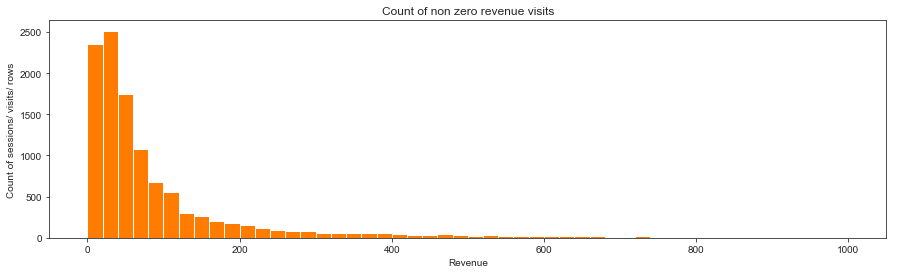

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(w=15,h=4)

ax.set_xlabel("Revenue")
ax.set_ylabel("Count of sessions/ visits/ rows")
ax.set_title("Count of non zero revenue visits")

_ = ax.hist(non_zero_revenues, bins=50, range=(0,1000), color=get_colors(1))

**This gives a rough picture that there are large number of small valued transactions and very few large valued.**

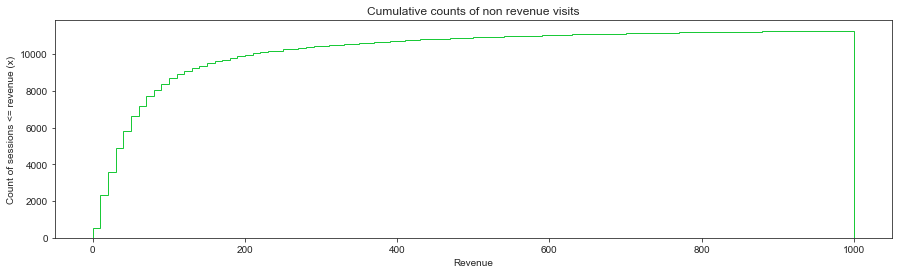

In [13]:
# cumulative distribution of the revenues
fig, ax = plt.subplots()
fig.set_size_inches(w=15,h=4)
ax.set_xlabel("Revenue")
ax.set_ylabel("Count of sessions <= revenue (x)")
ax.set_title("Cumulative counts of non revenue visits")
_ = ax.hist(non_zero_revenues,bins=100,range=(0,1000),cumulative=True,histtype='step', color=get_colors(1))

** This picture better shows that most of the non zero transactions have revenue of less than 200. In fact we see below that 90% of all revenues are less than 279. The median revenue is around $50. **

In [14]:
# revenues details
print("Minimum revenue per session: ", non_zero_revenues.min())
print("Maximum revenue per session: ", non_zero_revenues.max())
print("\nQuantiles for revenue per session: ")
print(non_zero_revenues.quantile(q=[0,0.1,0.25,0.5,0.75,0.9,1]))

Minimum revenue per session:  0.01
Maximum revenue per session:  23129.5

Quantiles for revenue per session: 
0.00        0.010
0.10       15.190
0.25       24.900
0.50       49.290
0.75      107.570
0.90      279.174
1.00    23129.500
Name: revenue, dtype: float64


In [15]:
# metadata about zero revenue transactions
train_df[train_df['totals.transactionRevenue']==0].describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,revenue
count,8.884230e+05,8.884230e+05,888423.000000,8.884230e+05,888423.000000,888423.000000,888423.000000,888423.000000,888423.0,888423.000000,888423.000000,888423.000000,888423.000000,888423.0
mean,2.016588e+07,1.484998e+09,2.235641,1.484998e+09,0.505211,4.187033,0.784450,3.532870,0.0,0.976405,0.023790,0.999999,0.298342,0.0
std,4.697277e+03,9.009761e+06,9.240935,9.009762e+06,0.499973,8.321397,0.411204,6.005968,0.0,0.151783,0.155402,0.001061,0.457531,0.0
min,2.016080e+07,1.470035e+09,1.000000,1.470035e+09,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
25%,2.016103e+07,1.477573e+09,1.000000,1.477573e+09,0.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.0
50%,2.017011e+07,1.483937e+09,1.000000,1.483937e+09,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.0
75%,2.017042e+07,1.492724e+09,1.000000,1.492724e+09,1.000000,4.000000,1.000000,3.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.0
max,2.017080e+07,1.501657e+09,395.000000,1.501657e+09,1.000000,500.000000,1.000000,429.000000,0.0,1.000000,14.000000,1.000000,1.000000,0.0


In [15]:
# other info for all non zero transaction revenues
train_df[train_df['totals.transactionRevenue']>0].describe()

,date,visitId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.campaignCode,trafficSource.isTrueDirect,revenue
count,1.146500e+04,1.146500e+04,11465.000000,1.146500e+04,11465.0,11465.000000,11465.000000,11465.000000,1.146500e+04,11465.000000,11465.000000,11465.0,11465.000000,11465.000000
mean,2.016622e+07,1.485875e+09,4.075796,1.485875e+09,0.0,36.237767,0.389359,28.297078,1.337719e+08,0.960576,0.039424,1.0,0.607065,133.771934
std,4.687124e+03,9.304643e+06,12.527615,9.304644e+06,0.0,30.084018,0.487626,21.520528,4.489875e+08,0.194611,0.194611,0.0,0.488424,448.987507
min,2.016080e+07,1.470046e+09,1.000000,1.470046e+09,0.0,2.000000,0.000000,2.000000,1.000000e+04,0.000000,0.000000,1.0,0.000000,0.010000
25%,2.016110e+07,1.478055e+09,1.000000,1.478055e+09,0.0,19.000000,0.000000,16.000000,2.490000e+07,1.000000,0.000000,1.0,0.000000,24.900000
50%,2.017013e+07,1.485554e+09,2.000000,1.485554e+09,0.0,28.000000,0.000000,23.000000,4.929000e+07,1.000000,0.000000,1.0,1.000000,49.290000
75%,2.017050e+07,1.493948e+09,4.000000,1.493948e+09,0.0,44.000000,1.000000,34.000000,1.075700e+08,1.000000,0.000000,1.0,1.000000,107.570000
max,2.017080e+07,1.501652e+09,315.000000,1.501652e+09,0.0,500.000000,1.000000,469.000000,2.312950e+10,1.000000,1.000000,1.0,1.000000,23129.500000


<div class="alert-success">&nbsp;</div>
Few things noticed by comparing revenue generating visits vs no-revenue visits
- Bounces are all zeros for revenue generating visits
- Campaign code are all ones
- Maximum visitNumber is 315 vs 395
- Minimum pageview is 2 vs 0
- Maximum pageviews is 469 vs 429
- Maximum adwordclickinfo page is 1 vs 14

So these all could serve as good features as they have differences in values for revenue vs no-revenue visits.



<div class="alert-success">&nbsp;</div>

### Analyze the visitorIds

#### Questions to ask:

- How many unique visitors for revenue vs non-revenue visits?
- There are 714167 unique visitor ids for the total of 903653 rows. What about the visitor ids of test set. Are the mutually exclusive than the train set ids?
- The revenues given are per user session?
- So is there a case where the same visitorId has revenue more than one time. Or in other words multiple rows for same visitorId have non-zero transaction revenue?

#### Proportion of unique visitorIds for revenue vs non-revenue sessions

In [16]:
# unique visitors with non zero revenue
unique_revenue_visits = train_df[train_df['totals.transactionRevenue'] > 0].fullVisitorId.unique().size

# with zero revenue
unique_zero_revenue_visits = train_df[train_df['totals.transactionRevenue'] == 0].fullVisitorId.unique().size

In [17]:
revenue_visits = train_df[train_df['totals.transactionRevenue'] > 0].shape[0]
zero_revenue_visits = train_df[train_df['totals.transactionRevenue'] == 0].shape[0]

In [18]:
print("Percentage of unique users for:")
print("\trevenue visits", unique_revenue_visits * 100 / revenue_visits)
print("\tnon revenue visits", unique_zero_revenue_visits * 100 / zero_revenue_visits)
print("\tall visits", train_df.fullVisitorId.nunique() * 100 / train_df.shape[0])

Percentage of unique users for:
	revenue visits 88.25992150021806
	non revenue visits 80.88129190712083
	all visits 80.25376491296694


** Percent for unique visitors is slightly more for revenue visits as compared to non revenue visits which is little weird because we would expect more visits by some visitor when they buy something.**

In [19]:
# groupby visitorId and get the count, mean, sum etc. for revenues
visitor_rev = train_df.groupby('fullVisitorId')['revenue'].agg(['count','mean','sum'])
visitor_rev_2 = train_df.groupby('fullVisitorId')['revenue'].apply(lambda x: np.count_nonzero(x))

In [20]:
visitor_rev_2.name = 'rev_num'
visitor_rev_2

fullVisitorId
4823595352351          0
5103959234087          0
10278554503158         0
20424342248747         0
26722803385797         0
                      ..
9999607385222235728    0
9999761280717362235    0
9999773079368714197    0
9999799804624735268    0
9999963186378918199    0
Name: rev_num, Length: 722194, dtype: int64

In [21]:
visitor_rev = visitor_rev.join(visitor_rev_2)

In [22]:
visitor_rev.describe()

,count,mean,sum,rev_num
count,722194.000000,722194.000000,722194.000000,722194.000000
mean,1.246047,0.786144,2.123661,0.015875
std,1.338417,16.783132,106.023850,0.153953
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,263.000000,3498.250000,75916.690000,30.000000


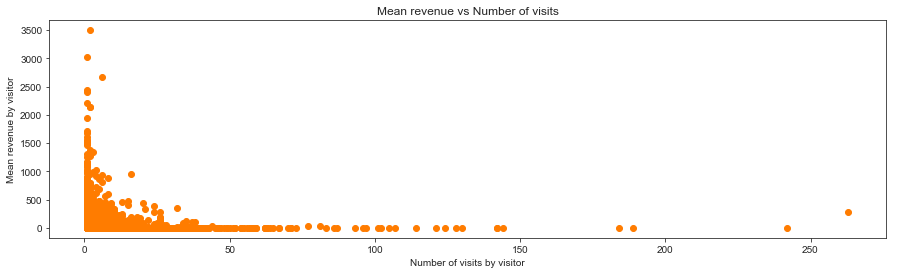

In [23]:
# plot count and mean scatter
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
ax.set_xlabel("Number of visits by visitor")
ax.set_ylabel("Mean revenue by visitor")
ax.set_title("Mean revenue vs Number of visits")
ax.scatter(visitor_rev['count'].values, visitor_rev['mean'].values, color=get_colors(1))

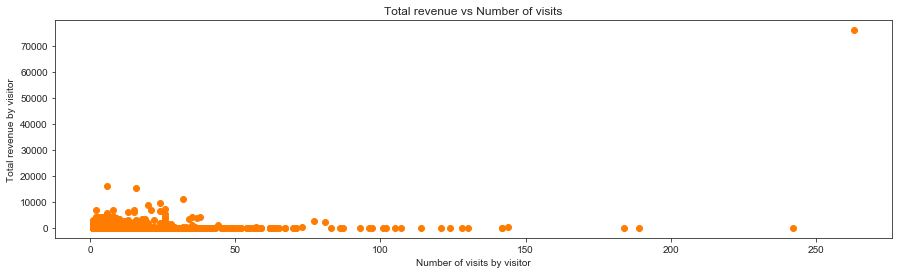

In [24]:
# plot count and sum scatter
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
ax.set_xlabel("Number of visits by visitor")
ax.set_ylabel("Total revenue by visitor")
ax.set_title("Total revenue vs Number of visits")
ax.scatter(visitor_rev['count'].values, visitor_rev['sum'].values, color=get_colors(1))

In [25]:
# let us investigate the visible outlier
visitor_rev[visitor_rev['count'] > 250]

,count,mean,sum,rev_num
fullVisitorId,,,,
1957458976293878100,263,288.656616,75916.69,15


In [26]:
# further
strange_visitor = visitor_rev[visitor_rev['count'] > 250].index
train_df[train_df['fullVisitorId'].isin(strange_visitor)]

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue
921,Organic Search,20160902,1957458976293878100,1957458976293878100_1472841771,1472841771,85,1472841771,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,0,22,0,16,0.000000e+00,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.00
1645,Organic Search,20160902,1957458976293878100,1957458976293878100_1472821703,1472821703,83,1472821703,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,0,3,0,3,0.000000e+00,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.00
1666,Organic Search,20160902,1957458976293878100,1957458976293878100_1472823804,1472823804,84,1472823804,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,0,5,0,5,0.000000e+00,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.00
4366,Organic Search,20170126,1957458976293878100,1957458976293878100_1485444781,1485444781,178,1485444781,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern America,0,3,0,3,0.000000e+00,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.00
6602,Display,20170623,1957458976293878100,1957458976293878100_1498248064,1498248064,309,1498248064,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,0,11,0,11,0.000000e+00,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,cpm,Unknown,dfa,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888632,Organic Search,20160907,1957458976293878100,1957458976293878100_1473250441,1473250441,87,1473250441,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,musfiber.com,not available in demo dataset,Northern America,0,3,0,3,0.000000e+00,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.00
891576,Display,20170324,1957458976293878100,1957458976293878100_1490380560,1490380560,237,1490380560,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,0,50,0,39,8.677830e+09,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,cpm,Unknown,dfa,8677.83
891587,Display,20170324,1957458976293878100,1957458976293878100_1490368999,1490368999,235,1490368999,Firefox,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcastbusiness.net,not available in demo dataset,Northern America,0,36,0,26,0.000000e+00,Others,Unknown,Un

In [27]:
print(list(train_df[train_df['fullVisitorId'].isin(strange_visitor)]['revenue']))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 234.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23129.5, 0.0, 25.77, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17855.5, 0.0, 0.0, 0.0, 0.0, 23.96, 173.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

**It wasn't an oulier just a visitor who spent huge as compared to others.**

In [28]:
count_1 = visitor_rev[visitor_rev['count']==1]

In [29]:
count_more_than_1 = visitor_rev[visitor_rev['count']>1]

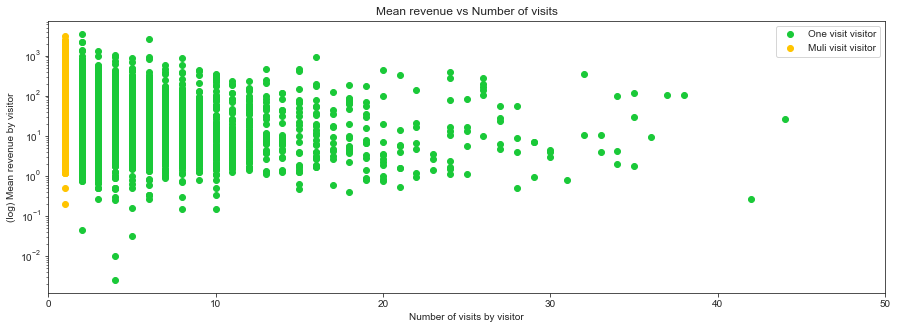

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax.set_yscale('log')
ax.set_xlim(0,50)
ax.set_xlabel("Number of visits by visitor")
ax.set_ylabel("(log) Mean revenue by visitor")
ax.set_title("Mean revenue vs Number of visits")

sct1 = ax.scatter(count_more_than_1['count'].values, count_more_than_1['mean'].values, c=get_colors(1))
sct2 = ax.scatter(count_1['count'].values, count_1['mean'].values, c=get_colors(1))

ax.legend((sct1, sct2), ('One visit visitor', 'Muli visit visitor'))


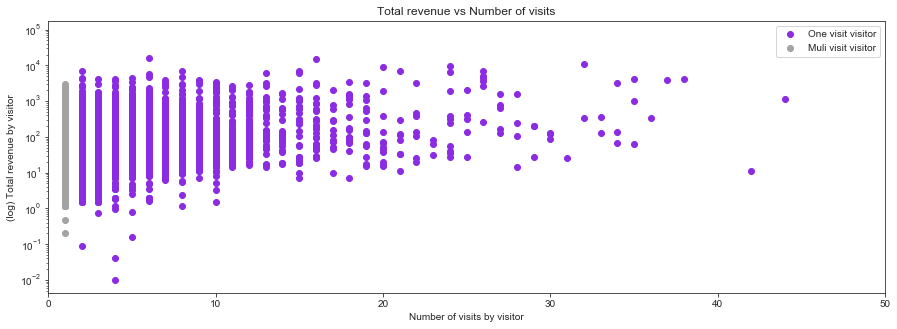

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax.set_yscale('log')
ax.set_xlim(0,50)
ax.set_xlabel("Number of visits by visitor")
ax.set_ylabel("(log) Total revenue by visitor")
ax.set_title("Total revenue vs Number of visits")
sct1 = ax.scatter(count_more_than_1['count'].values, count_more_than_1['sum'].values, c=get_colors(1))
sct2 = ax.scatter(count_1['count'].values, count_1['sum'].values, c=get_colors(1))
ax.legend((sct1, sct2), ('One visit visitor', 'Muli visit visitor'))

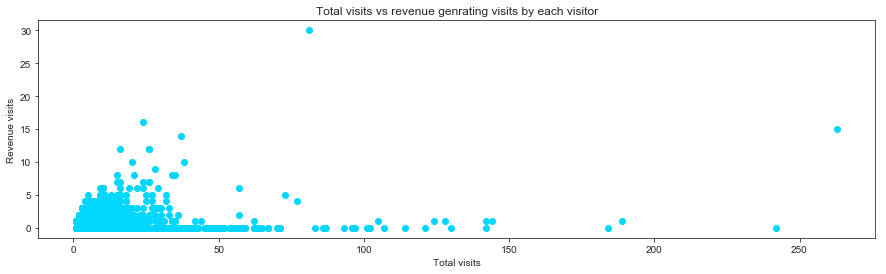

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(15,4)
#ax.set_xlim(0,50)
ax.set_xlabel("Total visits")
ax.set_ylabel("Revenue visits")
ax.set_title("Total visits vs revenue genrating visits by each visitor")
ax.scatter(visitor_rev['count'].values, visitor_rev['rev_num'].values, c=get_colors(1))

In [34]:
# when number of revenue visits by single visitor were more than one
visitor_rev[visitor_rev['rev_num'] > 2]

,count,mean,sum,rev_num
fullVisitorId,,,,
14262055593378383,8,5.335000,42.68,3
41955139058139143,9,30.746667,276.72,3
67516997967648879,4,37.655000,150.62,3
71298010648822329,11,25.769091,283.46,3
72595322994470645,6,64.091667,384.55,3
...,...,...,...,...
9970378027479686216,3,85.126667,255.38,3
9974232250427988367,7,454.118571,3178.83,3
280738376597848400,4,51.562500,206.25,3


In [35]:
# let us check what's the proportion of revenue visits for total number of visits by a visitor
visitor_rev['proportion_of_rev_visits'] = visitor_rev['rev_num']/visitor_rev['count']

In [36]:
visitor_rev.describe()

,count,mean,sum,rev_num,proportion_of_rev_visits
count,722194.000000,722194.000000,722194.000000,722194.000000,722194.000000
mean,1.246047,0.786144,2.123661,0.015875,0.008145
std,1.338417,16.783132,106.023850,0.153953,0.078981
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,263.000000,3498.250000,75916.690000,30.000000,1.000000


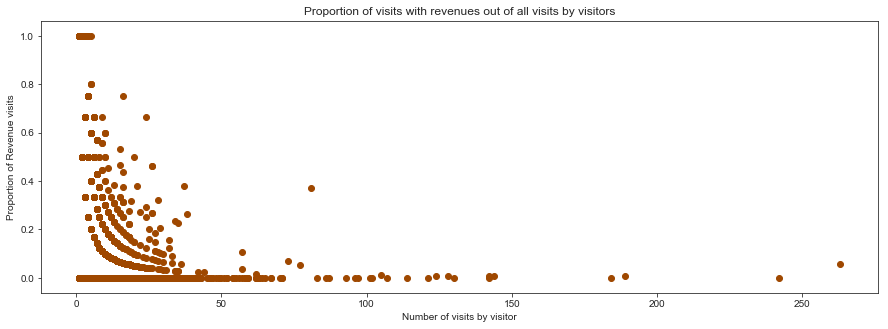

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
ax.set_xlabel("Number of visits by visitor")
ax.set_ylabel("Proportion of Revenue visits")
ax.set_title("Proportion of visits with revenues out of all visits by visitors")
ax.scatter(visitor_rev['count'].values, visitor_rev['proportion_of_rev_visits'].values, c=get_colors(1))

** Above all analysis means that when the number of visits by a visitor increases it necessarily doesn't mean that more revenue will be generated**

In [33]:
# let us see pattern of visits sorted by visitorId
temp_df = train_df.copy()
temp_df['fullVisitorId'] = temp_df['fullVisitorId'].astype(str)

sorted_train_df = temp_df.sort_values(by=['fullVisitorId'])

sorted_train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue
504385,Referral,20161222,0000500012543476818,0000500012543476818_1482465548,1482465548,1,1482465548,Chrome,desktop,False,Macintosh,Sunnyvale,Americas,United States,San Francisco-Oakland-San Jose CA,sbcglobal.net,California,Northern America,0,4,1,4,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,Unknown,referral,/,mall.googleplex.com,0.0
417796,Social,20161205,000084172700693338,000084172700693338_1480997717,1480997717,1,1480997717,Chrome,mobile,True,Android,not available in demo dataset,Asia,South Korea,not available in demo dataset,unknown.unknown,not available in demo dataset,Eastern Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,Unknown,referral,/yt/about/ko/,youtube.com,0.0
504492,Organic Search,20161222,0000945784447887116,0000945784447887116_1482427692,1482427692,1,1482427692,Chrome,desktop,False,Windows,not available in demo dataset,Americas,United States,not available in demo dataset,comcast.net,not available in demo dataset,Northern America,0,5,1,5,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0
41472,Direct,20161213,0001213046045394417,0001213046045394417_1481668412,1481668412,1,1481668412,Chrome,desktop,False,Macintosh,Irvine,Americas,United States,Los Angeles CA,(not set),California,Northern America,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,(none),Unknown,(direct),0.0
40559,Organic Search,20170630,0001285462512259769,0001285462512259769_1498822609,1498822609,1,1498822609,Safari,tablet,True,iOS,not available in demo dataset,Oceania,Australia,not available in demo dataset,dav.net.au,not available in demo dataset,Australasia,0,4,1,2,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0


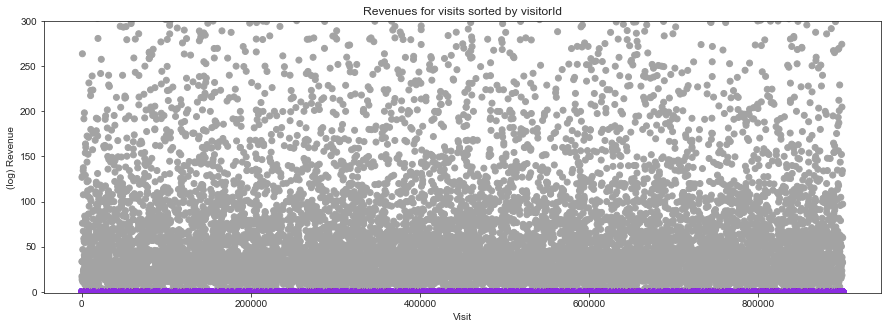

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
color1, color2 = get_colors(2)
color = [color1 if rev==0  else color2 for rev in sorted_train_df['revenue']]

ax.set_xlabel("Visit")
#ax.set_yscale('log')
ax.set_ylim(-1,300)
ax.set_ylabel("(log) Revenue")
ax.set_title("Revenues for visits sorted by visitorId")

ax.scatter(np.arange(0,sorted_train_df.shape[0]), sorted_train_df['revenue'].values, c=color)

<div class="alert-success">&nbsp;</div>
Understanding about visitorIds and revenues
- Revenues are evenly spread for all the visits
- Proportion of revenue visits decreases as the number of visits by the visitor increases. That is, if a visitor visits the site multiple times, it doesn't mean he/she is buying more and more.
- Total revenue increases slights if the number of visits increase
- Some visitors have generated revenue multiple times in multiple visits. Maximum is 30 revenue transactions by a visitor.

<div class="alert-success">&nbsp;</div>

### Analyze the date and visitStartTime

In [36]:
# function to draw various bar plots
def draw_bar_plot(x,heights,xlabels,ylabels,fig_w=16,fig_h=5,titles=None,xticklabels=None,xticks=None, x_rotation=0, nrows=False):
    if nrows:
        fig, axs = plt.subplots(nrows=len(heights))        
    else:
        fig, axs = plt.subplots(ncols=len(heights))
    fig.set_size_inches(w=fig_w,h=fig_h)
    
    bar_plots = []
    for ax,height,xlabel,ylabel in zip(axs,heights,xlabels,ylabels):
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:      
            ax.set_ylabel(ylabel)
        if titles:
            ax.set_title(title)
        if xticklabels:    
            ax.set_xticklabels(xticklabels, rotation=x_rotation, horizontalalignment="right")
        else:
            ax.set_xticklabels(x, rotation=x_rotation, horizontalalignment="right")
        if xticks:
            ax.set_xticks(xticks)
        else:
            ax.set_xticks(np.arange(0,len(x)))
        
        if nrows:  
            axs[0].set_xlabel("") 
            axs[0].set_xticklabels([])
        bar_plots.append(ax.bar(x,height,color=get_colors(1)))
        
    return bar_plots

In [37]:
train_df[['date','visitStartTime']]

,date,visitStartTime
0,20160902,1472830385
1,20160902,1472880147
2,20160902,1472865386
3,20160902,1472881213
4,20160902,1472822600
...,...,...
903648,20170104,1483554750
903649,20170104,1483543798
903650,20170104,1483526434
903651,20170104,1483592864


In [38]:
def get_time_fields(x):
    utc = pd.datetime.utcfromtimestamp(x)
    result = {'year': utc.year, 'month' : utc.month,'day': utc.day, 'weekday': utc.weekday(), 'hour': utc.hour}
    return pd.Series(result)

In [39]:
time_fields = train_df['visitStartTime'].apply(get_time_fields)
time_fields

,year,month,day,weekday,hour
0,2016,9,2,4,15
1,2016,9,3,5,5
2,2016,9,3,5,1
3,2016,9,3,5,5
4,2016,9,2,4,13
...,...,...,...,...,...
903648,2017,1,4,2,18
903649,2017,1,4,2,15
903650,2017,1,4,2,10
903651,2017,1,5,3,5


In [40]:
time_fields.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 5 columns):
year       899888 non-null int64
month      899888 non-null int64
day        899888 non-null int64
weekday    899888 non-null int64
hour       899888 non-null int64
dtypes: int64(5)
memory usage: 81.2 MB


In [41]:
train_df = train_df.join(time_fields)

train_df

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,2,4,15
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,5
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,1
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google,0.0,2016,9,3,5,5
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2016,9,2,4,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903648,Social,20170104,5123779100307500332,5123779100307500332_1483554750,1483554750,1,1483554750,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Puerto Rico,not available in demo dataset,prtc.net,not available in demo dataset,Caribbean,0,17,1,15,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,Unknown,referral,/yt/about/,youtube.com,0.0,2017,1,4,2,18
903649,Social,20170104,7231728964973959842,7231728964973959842_1483543798,1483543798,1,1483543798,Chrome,mobile,True,Android,not available in demo dataset,Asia,Sri Lanka,not available in demo dataset,unknown.unknown,not available in demo dataset,Southern Asia,0,18,1,13,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,Unknown,referral,/yt/about/,youtube.com,0.0,2017,1,4,2,15
903650,Social,20170104,5744576632396406899,5744576632396406899_1483526434,1483526434,1,1483526434,Android Webview,mobile,True,Android,Seoul,Asia,South Korea,(not set),unknown.unknown,Seoul,Eastern Asia,0,24,1,21,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,Unknown,referral,/yt/about/ko/,youtube.com,0.0,2017,1,4,2,10
903651,Social,20170104,2709355455991750775,2709355455991750775_1483592857,1483592857,1,1483592864,Chrome,desktop,False,Windows,not available in demo dat

In [43]:
month_rev = train_df.groupby('month')['revenue'].agg(['count','mean'])
months = [calendar.month_abbr[mon] for mon in month_rev.index.values]
print(months)

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


[<Container object of 12 artists>, <Container object of 12 artists>]

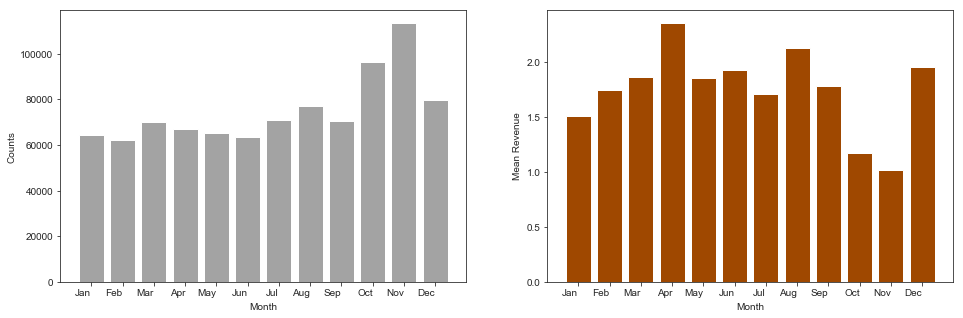

In [44]:
draw_bar_plot(month_rev.index.values,[list(month_rev['count'].values), list(month_rev['mean'].values)],\
              ['Month','Month'],['Counts','Mean Revenue'], xticklabels=(months), xticks=list(np.arange(1, 13)))

In [45]:
weekday_rev = train_df.groupby('weekday')['revenue'].agg(['count','mean'])
weekdays = [calendar.day_abbr[mon] for mon in weekday_rev.index.values]
print(weekdays)

['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


[<Container object of 7 artists>, <Container object of 7 artists>]

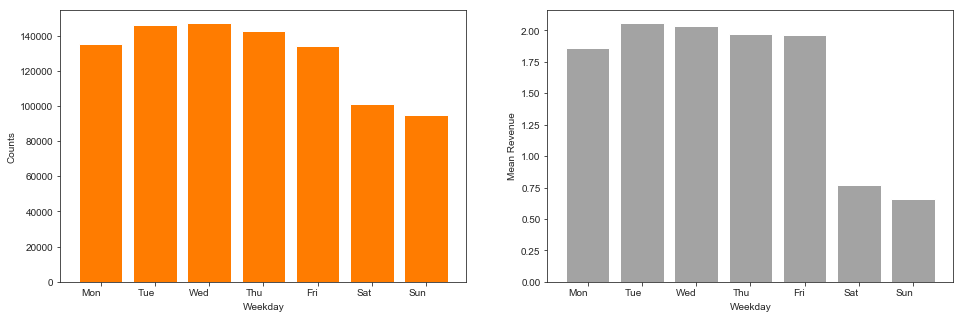

In [46]:
draw_bar_plot(weekday_rev.index.values,[list(weekday_rev['count'].values), list(weekday_rev['mean'].values)],\
              ['Weekday','Weekday'],['Counts','Mean Revenue'], xticklabels=(weekdays))

In [154]:
# dictionary to store lat, lon  for all city,country combo
location = defaultdict()
for x in train_df[['geoNetwork.city','geoNetwork.country']].drop_duplicates()[255:261].iterrows():
    city = x[1][0]
    country = x[1][1]
#     print(city, country)
    if(city not in ['(not set)','not available in demo dataset'] \
       & country not in ['(not set)','not available in demo dataset']):
            location[(city + ", " + country)] = geolocator.geocode(city + ", " + country)
#     print(location[(city + ", " + country)].latitude)

not available in demo dataset Congo - Kinshasa
not available in demo dataset New Caledonia
not available in demo dataset Rwanda
not available in demo dataset Kyrgyzstan
not available in demo dataset Bolivia
not available in demo dataset Tanzania


In [170]:
# get visitStartTime by time zone
tf = timezonefinder.TimezoneFinder()
def get_time_for_city(x):
    #print(x)
    dt = x['visitStartTime']
    city = x['geoNetwork.city']
    country = x['geoNetwork.country']
    utc = pd.datetime.utcfromtimestamp(dt)

    city_country = location.get((city + ", " + country), None)
    if(city_country):
    # Get the tz-database-style time zone name (e.g. 'America/Vancouver') or None
        timezone_str = tf.certain_timezone_at(lat=city_country.latitude, lng=city_country.longitude)
        if timezone_str:
            return utc.astimezone(tz.gettz(timezone_str)).hour
    else:
        return utc.hour

In [134]:
train_df[['visitStartTime','geoNetwork.city','geoNetwork.country']].nunique()

visitStartTime        883517
geoNetwork.city          649
geoNetwork.country       222
dtype: int64

In [171]:
train_df['local_hour'] = train_df[['visitStartTime','geoNetwork.city', \
                                   'geoNetwork.country']].apply(lambda x: get_time_for_city(x), axis=1)

In [172]:
train_df['local_hour']

0          1
1          5
2         10
3          5
4         13
          ..
903648    18
903649    15
903650     3
903651     5
903652     0
Name: local_hour, Length: 899888, dtype: int64

[<Container object of 24 artists>, <Container object of 24 artists>]

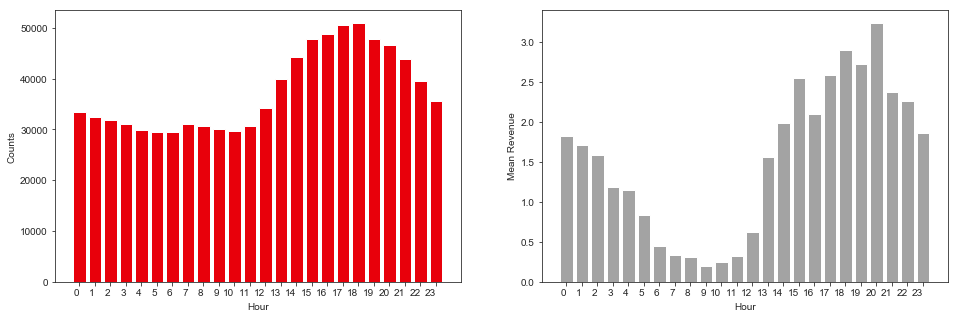

In [47]:
# this might not be that useful because of different geo locations, but we will see that later
hour_rev = train_df.groupby('hour')['revenue'].agg(['count','mean'])
draw_bar_plot(hour_rev.index.values,[list(hour_rev['count'].values), list(hour_rev['mean'].values)],\
              ['Hour','Hour'],['Counts','Mean Revenue'])

[<Container object of 24 artists>, <Container object of 24 artists>]

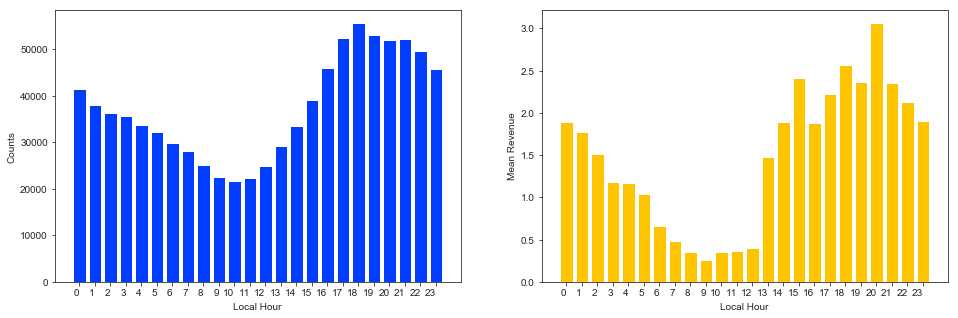

In [174]:
# now depending on different geo locations
local_hour_rev = train_df.groupby('local_hour')['revenue'].agg(['count','mean'])
draw_bar_plot(local_hour_rev.index.values,[list(local_hour_rev['count'].values), list(local_hour_rev['mean'].values)],\
              ['Local Hour','Local Hour'],['Counts','Mean Revenue'])

[<Container object of 31 artists>, <Container object of 31 artists>]

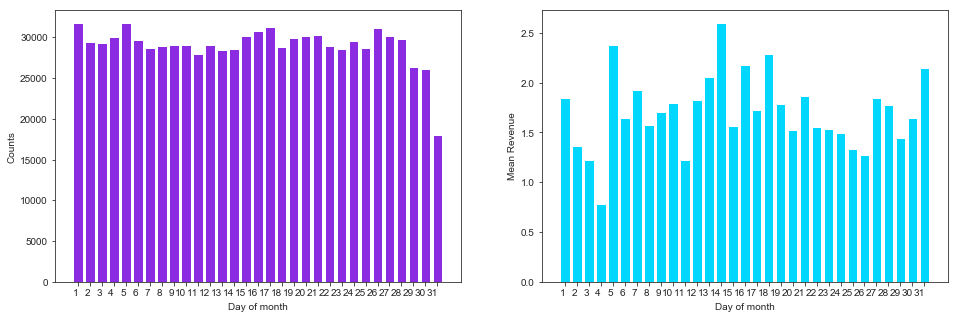

In [48]:
# this might not be that useful because of different geo locations, but we will see that later
day_rev = train_df.groupby('day')['revenue'].agg(['count','mean'])
draw_bar_plot(day_rev.index.values,[list(day_rev['count'].values), list(day_rev['mean'].values)],\
              ['Day of month','Day of month'],['Counts','Mean Revenue'], xticks=list(np.arange(1, 32)))

In [72]:
# convert date into day
def date_to_day(dt, min_date):
    cur_date = datetime.date(dt.year, dt.month, dt.day)
    start_year_date = datetime.date(dt.year, 1, 1)
    return (cur_date - start_year_date).days

In [73]:
# subtract the min date from all dates to get the days
min_date_str = str(train_df.date.min())
min_date = datetime.date(np.int(min_date_str[0:4]),np.int(min_date_str[4:6]),np.int(min_date_str[6:8]))

In [75]:
train_df["day_of_year"] = train_df[['year','month','day']].apply(lambda x: date_to_day(x,min_date),axis=1)

In [76]:
train_df['day_of_year'].describe()

count    899888.000000
mean        196.583169
std         106.808824
min           0.000000
25%         102.000000
50%         206.000000
75%         296.000000
max         365.000000
Name: day_of_year, dtype: float64

In [77]:
# how does the revenue data look when sorted by date time
sorted_day_of_year = train_df.sort_values(by=['day_of_year'])
sorted_day_of_year

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year
802015,Organic Search,20170101,4143103192262352782,4143103192262352782_1483259629,1483259629,1,1483259629,Android Webview,mobile,True,Android,not available in demo dataset,Americas,Peru,not available in demo dataset,unknown.unknown,not available in demo dataset,South America,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2017,1,1,6,8,0
848449,Direct,20161231,999399625651870940,999399625651870940_1483243374,1483243374,2,1483243374,Chrome,mobile,True,Android,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,(none),Unknown,(direct),0.0,2017,1,1,6,4,0
802189,Organic Search,20170101,3959993628782510755,3959993628782510755_1483304999,1483304999,3,1483304999,Chrome,desktop,False,Windows,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,virginm.net,not available in demo dataset,Northern Europe,0,2,0,2,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2017,1,1,6,21,0
802191,Direct,20170101,4046777890654563839,4046777890654563839_1483311613,1483311613,3,1483311613,Chrome,tablet,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,0,2,0,2,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,(none),Unknown,(direct),0.0,2017,1,1,6,23,0
848457,Referral,20161231,8822330087284720002,8822330087284720002_1483248641,1483248641,7,1483248641,Chrome,desktop,False,Macintosh,San Jose,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,referral,/a/google.com/googletopia/discounts-deals-and-...,sites.google.com,0.0,2017,1,1,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102238,Organic Search,20161230,7877743794974819551,7877743794974819551_1483166927,1483166927,1,1483166927,Chrome,mobile,True,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,0,3,1,3,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,12,31,5,6,365
101798,Direct,20161230,5921359766515283511,5921359766515283511_1483159453,1483159453,1,1483159453,Chrome,desktop,False,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,(none),Unknown,(direct),0.0,2016,12,31,5,4,365
849145,Social,20161231,6226865998177749808,6226865998177749808_1483206942,1483206942,1,1483206942,Chrome,desktop,False,Macintosh,not available in demo dataset,Asia,United Arab Emirates,not available in demo dataset,alshamil.net.ae,not available in demo dataset,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,Unknown,referr

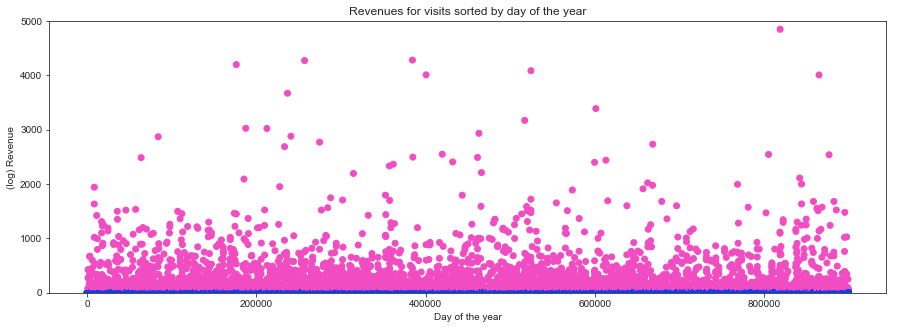

In [78]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
color1, color2 = get_colors(2)
color = [color1 if rev==0  else color2 for rev in sorted_day_of_year['revenue']]

ax.set_xlabel("Day of the year")
#ax.set_yscale('log')
ax.set_ylim(-1,5000)
ax.set_ylabel("(log) Revenue")
ax.set_title("Revenues for visits sorted by day of the year")

ax.scatter(np.arange(0,sorted_day_of_year.shape[0]), sorted_day_of_year['revenue'].values, c=color)

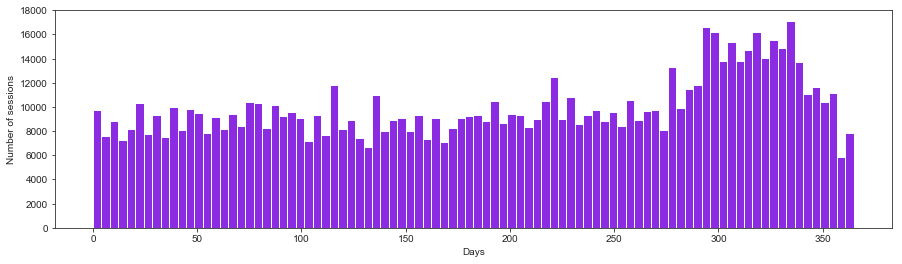

In [80]:
# plot the days
fig, ax = plt.subplots()
fig.set_size_inches(w=15,h=4)
ax.set_xlabel("Days")
ax.set_ylabel("Number of sessions")
_ = ax.hist(train_df.day_of_year,bins=90,color=get_colors(1))

In [56]:
# how does the revenue data look when sorted by visit start time
sorted_visit_time = train_df.sort_values(by=['visitStartTime'])
sorted_visit_time

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year
538675,Direct,20160801,423043652415339154,0423043652415339154_1470034812,1470034812,3,1470034812,Safari,mobile,True,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,(none),Unknown,(direct),0.0,2016,8,1,0,7,0
538232,Social,20160801,8294721032567046680,8294721032567046680_1470035066,1470035066,1,1470035066,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Thailand,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,Unknown,referral,/yt/about/,youtube.com,0.0,2016,8,1,0,7,0
539087,Organic Search,20160801,7718623669497357235,7718623669497357235_1470035081,1470035081,1,1470035081,Amazon Silk,tablet,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,0,5,1,5,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,8,1,0,7,0
539300,Organic Search,20160801,4798058133221713505,4798058133221713505_1470035161,1470035161,1,1470035161,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Canada,not available in demo dataset,bell.ca,not available in demo dataset,Northern America,0,9,1,7,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,8,1,0,7,0
538453,Direct,20160801,5076747981380011349,5076747981380011349_1470035170,1470035170,1,1470035170,Chrome,desktop,False,Windows,Quezon City,Asia,Philippines,(not set),pldt.net,Metro Manila,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,Unknown,(none),Unknown,(direct),0.0,2016,8,1,0,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64597,Affiliates,20170801,3288761792927926647,3288761792927926647_1501657161,1501657161,1,1501657161,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Israel,not available in demo dataset,axerra.org.il,not available in demo dataset,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,Data Share Promo,1,0,Unknown,affiliate,Unknown,Partners,0.0,2017,8,2,2,6,366
64767,Organic Search,20170801,9952572636180683443,9952572636180683443_1501657166,1501657166,1,1501657166,Chrome,desktop,False,Windows,not available in demo dataset,Asia,China,not available in demo dataset,163data.com.cn,not available in demo dataset,Eastern Asia,0,2,1,2,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2017,8,2,2,6,366
65054,Organic Search,20170801,3800266955937177725,3800266955937177725_1501657186,1501657186,3,1501657186,Internet Explorer,desktop,False,Windows,London,Europe,United Kingdom,London,kingston.ac.uk,England,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2017,8,2,2,6,366
65294,Social,20170801,6344531343964394726,63445313

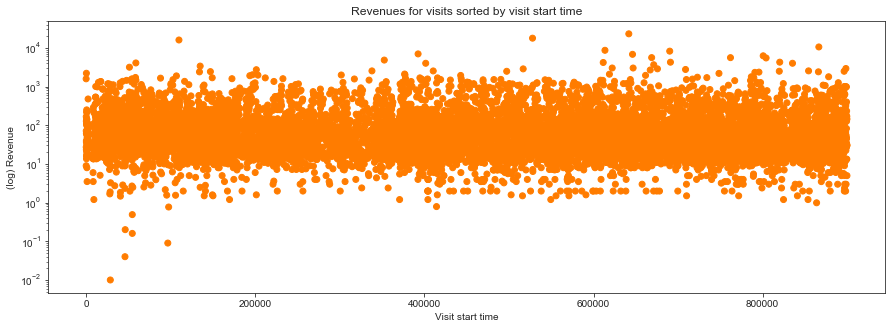

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
color1, color2 = get_colors(2)
color = [color1 if rev==0  else color2 for rev in sorted_visit_time['revenue']]

ax.set_xlabel("Visit start time")
ax.set_yscale('log')
#ax.set_ylim(-1,5000)
ax.set_ylabel("(log) Revenue")
ax.set_title("Revenues for visits sorted by visit start time")

ax.scatter(np.arange(0,sorted_visit_time.shape[0]), sorted_visit_time['revenue'].values, c=color)

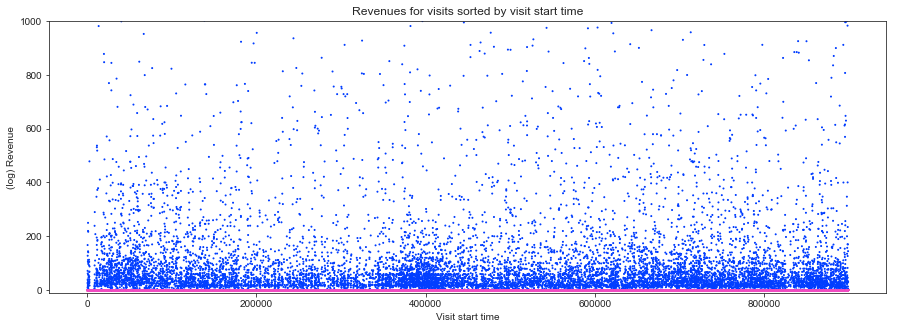

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
color1, color2 = get_colors(2)
color = [color1 if rev==0  else color2 for rev in sorted_visit_time['revenue']]

ax.set_xlabel("Visit start time")
#ax.set_yscale('log')
#ax.set_xlim(0,1000)
ax.set_ylim(-10,1000)
ax.set_ylabel("(log) Revenue")
ax.set_title("Revenues for visits sorted by visit start time")

ax.scatter(np.arange(0,sorted_visit_time.shape[0]), sorted_visit_time['revenue'].values, c=color, s=1)

In [239]:
# group by days and check the revenues per day
day_rev = train_df.groupby('day_of_year')['revenue'].agg(['count','mean','sum'])
day_rev_2 = train_df.groupby('day_of_year')['revenue'].apply(lambda x: np.count_nonzero(x))

In [240]:
day_rev = day_rev.join(day_rev_2)
day_rev

,count,mean,sum,revenue
day_of_year,,,,
0,1228,0.745326,915.26,7
1,1562,0.681793,1064.96,16
2,2306,1.491518,3439.44,35
3,2355,1.443091,3398.48,27
4,2278,3.111870,7088.84,37
...,...,...,...,...
361,1821,0.866612,1578.10,22
362,1802,2.019007,3638.25,22
363,1676,1.669505,2798.09,19


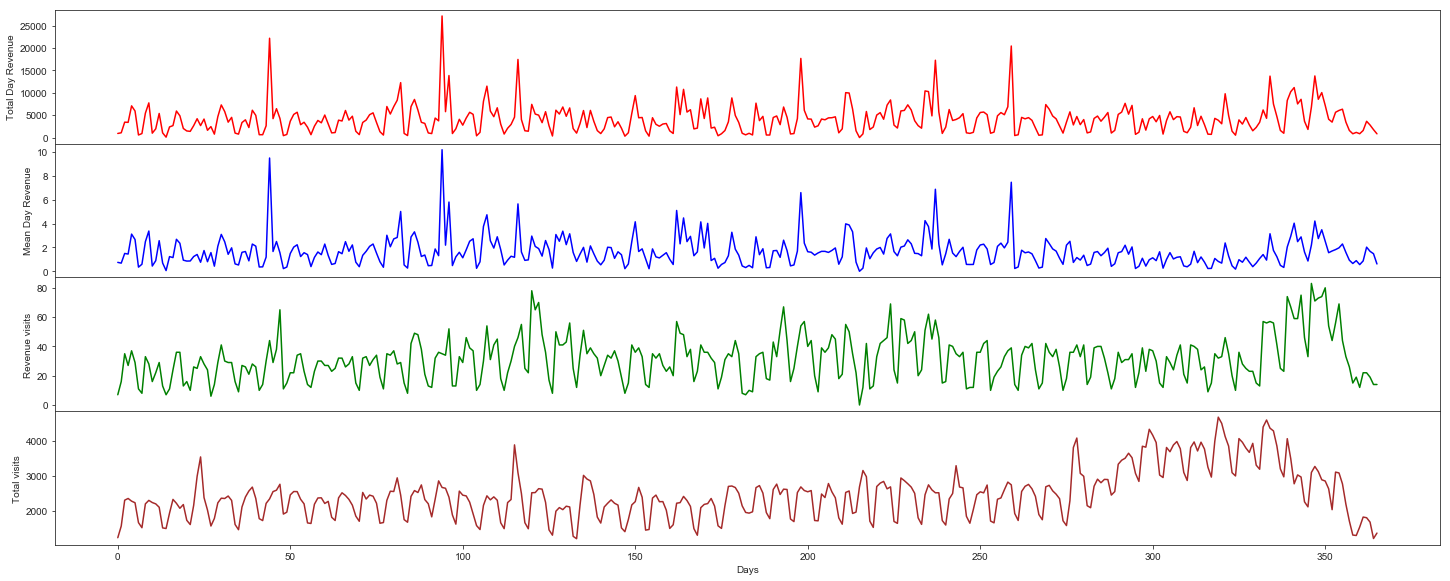

In [241]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=8)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Days")
ax[0].set_ylabel("Total Day Revenue")
ax[1].set_ylabel("Mean Day Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

x = np.arange(0,day_rev.shape[0])
plt1 = ax[0].plot(x,day_rev['sum'].values, color='red')
plt2 = ax[1].plot(x,day_rev['mean'].values, color='blue')
plt3 = ax[2].plot(x,day_rev['revenue'].values, color='green')
plt3 = ax[3].plot(x,day_rev['count'].values, color='brown')

<div class="alert-success">&nbsp;</div>
Understanding about date and visitStartTime

- The visit counts increase in the festival months. But the mean revenue fluctuates in those months.
- Both the visit counts and mean revenues drop on weekends. May be people are busy doing other stuff then buying things online.
- Assuming large portion of visitors are from North America, the 24 hour pattern shows mean revenue increase in day time, maximizes around 8pm and then drops.
- We dont see any pattern for day of the month mean revenue. And the visit counts are pretty uniform. It means all days of the month are same as far as visiting the GStore is considered.
- We see weekly patterns for visits and therefore mean and total revenues. And although the visits surge around 50-120 days the mean revenues surge around 120-150 days.

<div class="alert-success">&nbsp;</div>

#### Analyze visitNumber - visit number of a visitor

In [65]:
print(train_df.visitNumber.unique())

[  1   2   3   5  11   4  57   6  56   7  20   8  15   9  25  24  14  89
 136  13  85  10 105  22  21  48  18  26  17  83  38  84  27  42 100  31
  16  30  59  50  19  51  29 160  52  12  63  23  47  49  28  34 178  88
  33 317  93 140  35  41  91  92  74 309  43  61  46  45  32 108  86 195
  36 236  72 162 235  90  76  77  94  96  73  78  97  87 304 106 107 389
  68  98 132  58 266 267 221  39 121 143 142 174 175 189 191  55 190 104
 245 204  37  82 137 206 101  62 110 156 158 157 159 138 109 194 193 147
 254  71  53 144 145 146  80 253 134 135 102  44 130  95  75 103 315  70
  69 117 163 154 153 283  65 262 263 295 297 298 219  64 296 155 141 169
 170  60 207  54 187 133 118 264  67  66 126  40 122 325 326 197 167 196
 188 279 185 230 161 186 278 139 234 233 168 115 114 119 150 149 148  79
 306 123 131 171 124 129 258 112 218 183 199 261 259 260 200 220 152 151
 111 202 203 205 173 125 198 280 281 177 182 127 120 116  81 373 113 212
 213 226 225 348 224 128 176 269 250 355 370 285 36

In [66]:
print("No. of unique visitNumber: ", train_df.visitNumber.unique().size)

No. of unique visitNumber:  384


In [67]:
train_df.visitNumber.describe()

count    899888.000000
mean          2.259086
std           9.292407
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         395.000000
Name: visitNumber, dtype: float64

In [68]:
# group by days and check the revenues per day
visit_no_rev = train_df.groupby('visitNumber')['revenue'].agg(['count','mean','sum'])
visit_no_rev_2 = train_df.groupby('visitNumber')['revenue'].apply(lambda x: np.count_nonzero(x))

In [69]:
visit_no_rev = visit_no_rev.join(visit_no_rev_2)
visit_no_rev

,count,mean,sum,revenue
visitNumber,,,,
1,701387,0.544871,382165.42,4464
2,91826,2.962847,272066.40,2494
3,35449,5.478390,194203.45,1420
4,18897,6.785591,128227.31,874
5,11463,8.389697,96171.10,550
...,...,...,...,...
390,1,0.000000,0.00,0
391,1,0.000000,0.00,0
393,1,0.000000,0.00,0


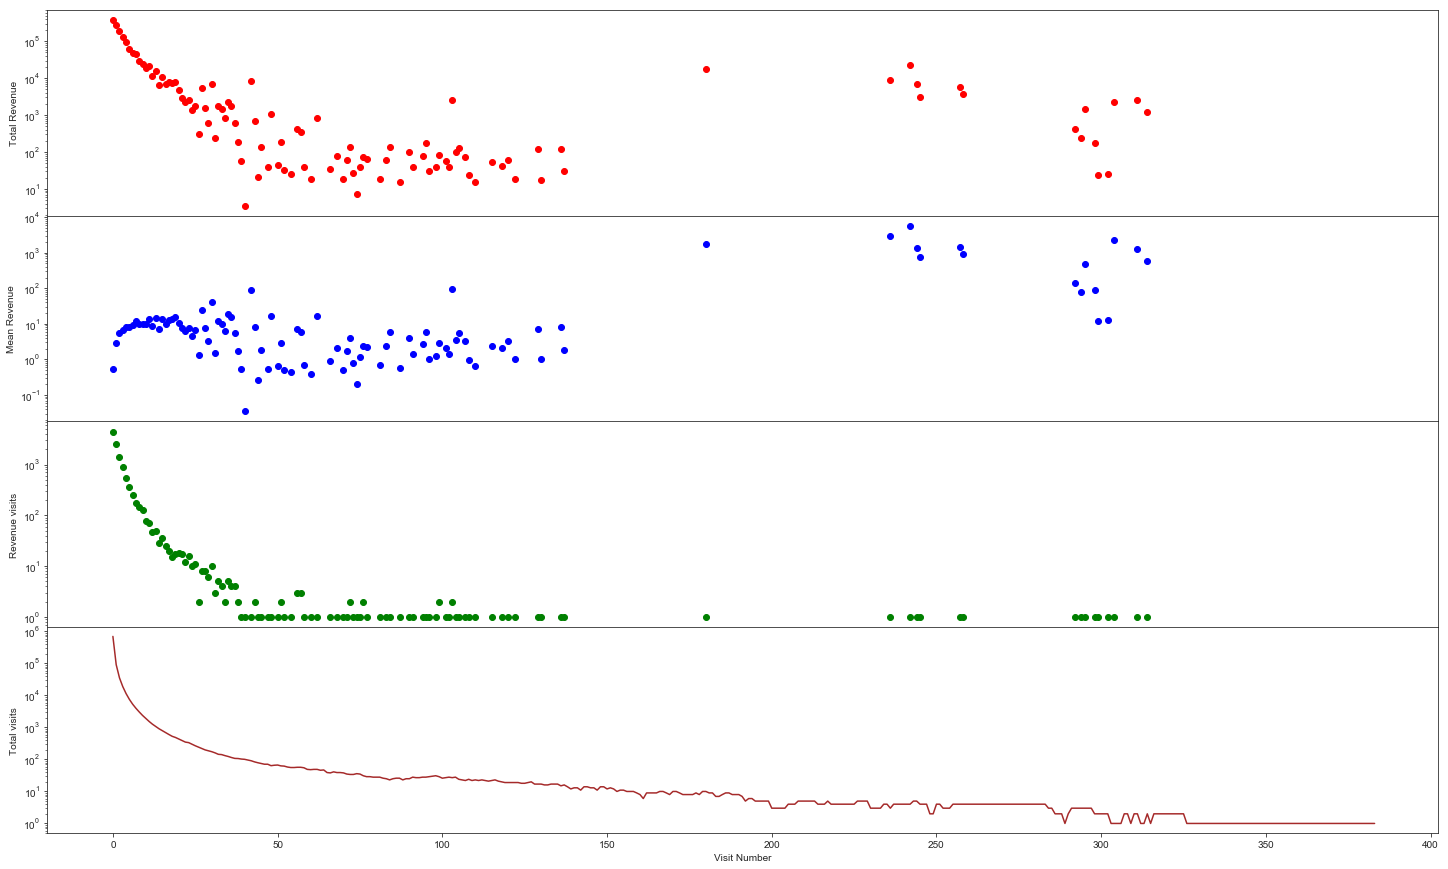

In [70]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Visit Number")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,visit_no_rev.shape[0])
plt1 = ax[0].scatter(x,visit_no_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,visit_no_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,visit_no_rev['revenue'].values, color='green')
plt3 = ax[3].plot(x,visit_no_rev['count'].values, color='brown')

<div class="alert-success">&nbsp;</div>
Understanding about visitNumber

- Most of the visitors visit less than 5 times. For e.g. number of visit first or second time is around 1 million and it drops very fast. Very few visitors visit for more than 50th time or more.

- Same is the case for visits that produce revenue.

- It is little strange that there are very few revenue visits such that it is 150-250th visit for that visitor.

- Mean revenues are uniformly distributed from 0.1 to 10 for visit numbers 1 to 150. And it is significantly higher for greater visit numbers. It indicates that oftern more number of visits are needed before high valued purchase.

<div class="alert-success">&nbsp;</div>

#### Analyze channelGrouping

In [175]:
# unique channels
train_df.channelGrouping.unique()

array(['Organic Search', 'Referral', 'Paid Search', 'Affiliates',
       'Direct', 'Display', 'Social', '(Other)'], dtype=object)

[<Container object of 8 artists>, <Container object of 8 artists>]

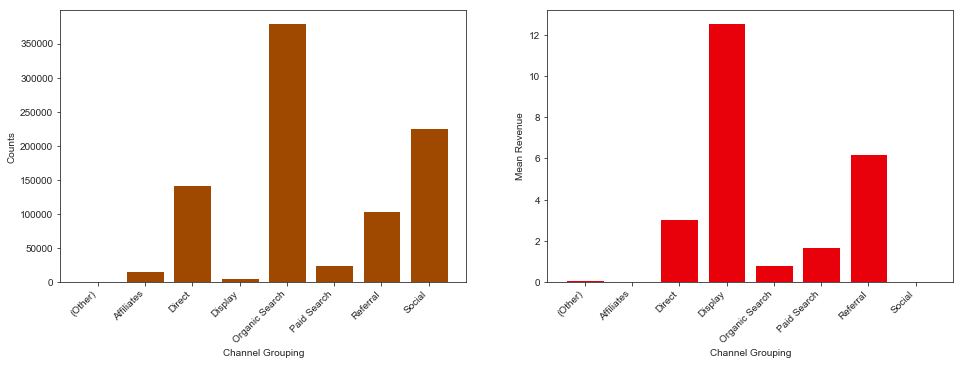

In [72]:
channel_rev = train_df.groupby('channelGrouping')['revenue'].agg(['count','mean'])
draw_bar_plot(channel_rev.index.values,[list(channel_rev['count'].values), list(channel_rev['mean'].values)],\
              ['Channel Grouping','Channel Grouping'],['Counts','Mean Revenue'], x_rotation=45)

#### Analyze device fields

In [73]:
# unique device browser
train_df['device.browser'].unique()

array(['Chrome', 'Firefox', 'UC Browser', 'Internet Explorer', 'Safari',
       'Edge', 'Opera Mini', 'Opera', 'BlackBerry', 'Safari (in-app)',
       'Coc Coc', 'Mozilla Compatible Agent', 'ADM', 'MRCHROME',
       'Amazon Silk', 'YaBrowser', 'Android Webview', 'Puffin',
       'Nokia Browser', 'Maxthon', 'Nintendo Browser', 'Android Browser',
       'Lunascape', 'IE with Chrome Frame', 'ThumbSniper',
       'LYF_LS_4002_12', 'Mozilla', 'osee2unifiedRelease', 'NokiaE52-1',
       'Iron', '[Use default User-agent string] LIVRENPOCHE', '(not set)',
       'LYF_LS_4002_11', 'M5', 'Android Runtime', 'Apple-iPhone7C2',
       'SeaMonkey', 'Konqueror', 'Seznam', 'Changa 99695759', 'no-ua',
       'MQQBrowser', 'Nichrome', 'DASH_JR_3G', 'DoCoMo',
       'subjectAgent: NoticiasBoom', 'YE', 'User Agent', '0',
       'Hisense M20-M_LTE', 'Reddit', 'TCL P500M', 'CSM Click'],
      dtype=object)

[<Container object of 53 artists>, <Container object of 53 artists>]

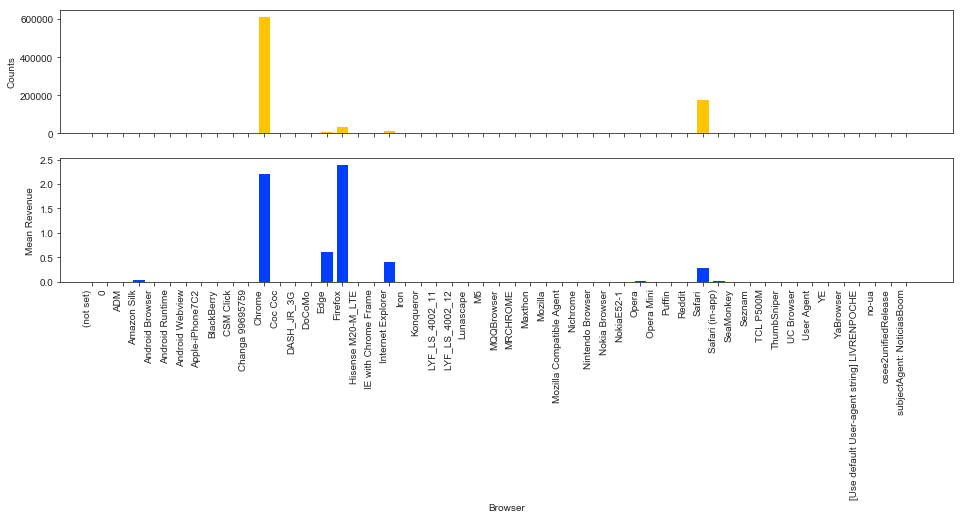

In [74]:
browser_rev = train_df.groupby('device.browser')['revenue'].agg(['count','mean'])
draw_bar_plot(browser_rev.index.values,[list(browser_rev['count'].values), list(browser_rev['mean'].values)],\
              ['Browser','Browser'],['Counts','Mean Revenue'], x_rotation=90, nrows=True)

In [75]:
# unique device category
train_df['device.deviceCategory'].unique()

array(['desktop', 'mobile', 'tablet'], dtype=object)

[<Container object of 3 artists>, <Container object of 3 artists>]

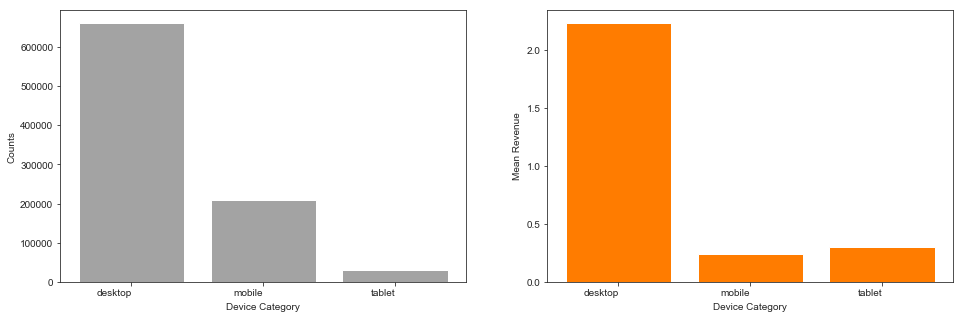

In [76]:
device_rev = train_df.groupby('device.deviceCategory')['revenue'].agg(['count','mean'])
draw_bar_plot(device_rev.index.values,[list(device_rev['count'].values), list(device_rev['mean'].values)],\
              ['Device Category','Device Category'],['Counts','Mean Revenue'])

In [77]:
# unique device category
train_df['device.isMobile'].unique()

array([False,  True])

[<Container object of 2 artists>, <Container object of 2 artists>]

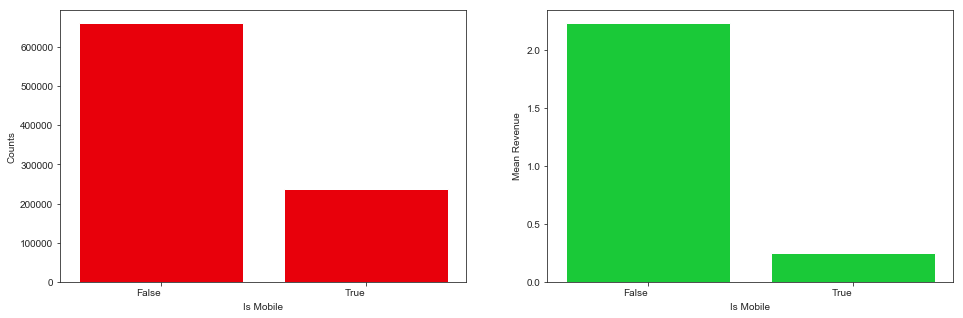

In [78]:
mobile_rev = train_df.groupby('device.isMobile')['revenue'].agg(['count','mean'])
draw_bar_plot(mobile_rev.index.values,[list(mobile_rev['count'].values), list(mobile_rev['mean'].values)],\
              ['Is Mobile','Is Mobile'],['Counts','Mean Revenue'])

In [79]:
# unique device category
train_df['device.operatingSystem'].unique()

array(['Windows', 'Macintosh', 'Linux', 'Android', 'iOS', 'Chrome OS',
       'BlackBerry', '(not set)', 'Samsung', 'Windows Phone', 'Xbox',
       'Nintendo Wii', 'Firefox OS', 'Nintendo WiiU', 'FreeBSD', 'Nokia',
       'NTT DoCoMo', 'Nintendo 3DS', 'SunOS', 'OpenBSD'], dtype=object)

[<Container object of 20 artists>, <Container object of 20 artists>]

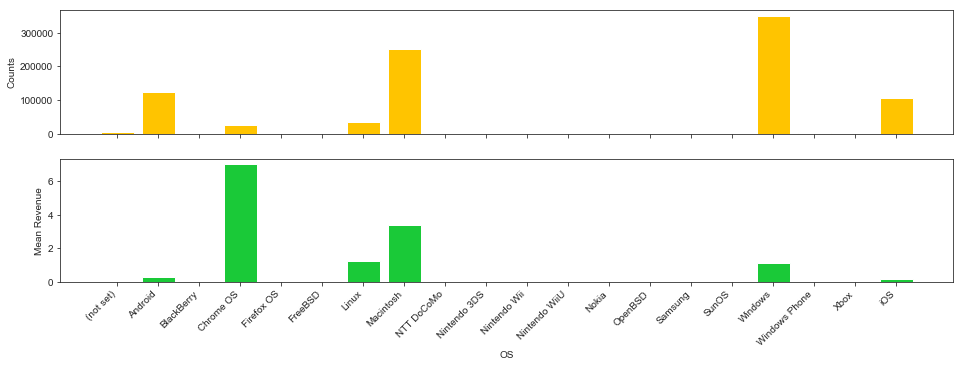

In [80]:
os_rev = train_df.groupby('device.operatingSystem')['revenue'].agg(['count','mean'])
draw_bar_plot(os_rev.index.values,[list(os_rev['count'].values), list(os_rev['mean'].values)],\
              ['OS','OS'],['Counts','Mean Revenue'], x_rotation=45, nrows=True)

### What effect does geoNetwork fields have on revenue? 
- What all cities, countries access the GStore?
- Are metro areas spending more?
- Are there any specific patterns related to city, country etc.?

In [176]:
# Check various geo distributions
continent_counts = train_df.groupby('geoNetwork.continent')['date'].count()
continent_counts

geoNetwork.continent
(not set)      1460
Africa        14719
Americas     449352
Asia         222791
Europe       196550
Oceania       15016
Name: date, dtype: int64

In [177]:
continent_counts.index.values, continent_counts.values

(array(['(not set)', 'Africa', 'Americas', 'Asia', 'Europe', 'Oceania'],
       dtype=object), array([  1460,  14719, 449352, 222791, 196550,  15016]))

[<Container object of 6 artists>, <Container object of 6 artists>]

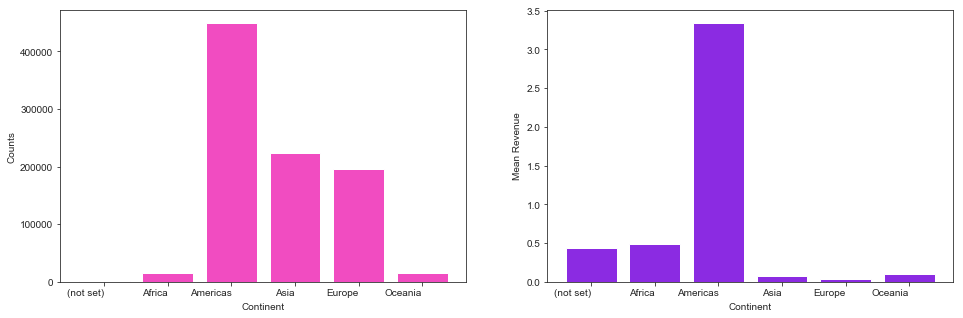

In [179]:
continent_rev = train_df.groupby('geoNetwork.continent')['revenue'].agg(['count','mean'])
draw_bar_plot(continent_rev.index.values,[list(continent_rev['count'].values), list(continent_rev['mean'].values)],\
              ['Continent','Continent'],['Counts','Mean Revenue'])

In [180]:
# rev counts
continent_rev_counts = train_df.groupby('geoNetwork.continent')['revenue'].apply(lambda x: np.count_nonzero(x))
continent_rev_counts

geoNetwork.continent
(not set)        5
Africa           7
Americas     11252
Asia           122
Europe          67
Oceania         12
Name: revenue, dtype: int64

In [181]:
# rev counts
continent_non_rev_counts = train_df[train_df['revenue']==0].groupby('geoNetwork.continent')['revenue'].count()
continent_non_rev_counts

geoNetwork.continent
(not set)      1455
Africa        14712
Americas     438100
Asia         222669
Europe       196483
Oceania       15004
Name: revenue, dtype: int64

[<Container object of 6 artists>, <Container object of 6 artists>]

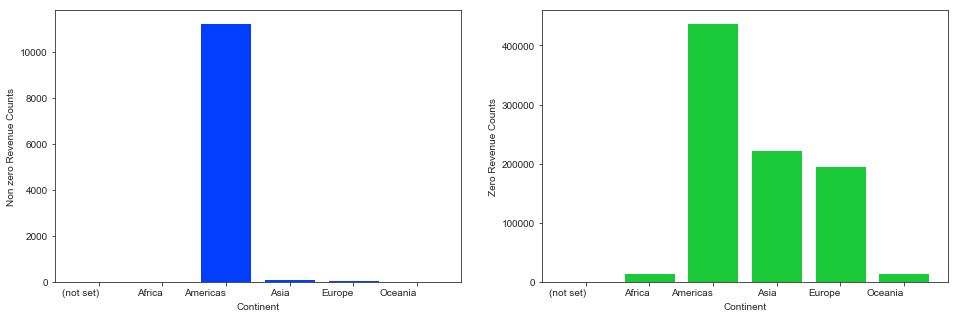

In [183]:
draw_bar_plot(continent_rev_counts.index.values,[list(continent_rev_counts.values), list(continent_non_rev_counts.values)],\
              ['Continent','Continent'],['Non zero Revenue Counts','Zero Revenue Counts'])

[<Container object of 23 artists>, <Container object of 23 artists>]

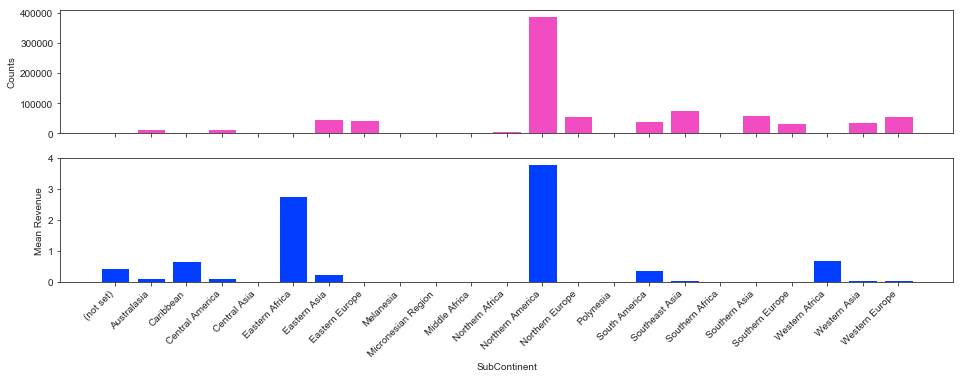

In [186]:
sub_continent_rev = train_df.groupby('geoNetwork.subContinent')['revenue'].agg(['count','mean'])
draw_bar_plot(sub_continent_rev.index.values,[list(sub_continent_rev['count'].values), list(sub_continent_rev['mean'].values)],\
              ['SubContinent','SubContinent'],['Counts','Mean Revenue'],x_rotation=45, nrows=True)

In [187]:
# unique country
print(train_df['geoNetwork.country'].unique())

['Turkey' 'Australia' 'Spain' 'Indonesia' 'United Kingdom' 'Italy'
 'Pakistan' 'Austria' 'Netherlands' 'India' 'France' 'Brazil' 'China'
 'Singapore' 'Argentina' 'Poland' 'Germany' 'Canada' 'Thailand' 'Hungary'
 'Malaysia' 'Denmark' 'Taiwan' 'Russia' 'Nigeria' 'Belgium' 'South Korea'
 'Chile' 'Ireland' 'Philippines' 'Greece' 'Mexico' 'Montenegro'
 'United States' 'Bangladesh' 'Japan' 'Slovenia' 'Czechia' 'Sweden'
 'United Arab Emirates' 'Switzerland' 'Portugal' 'Peru' 'Hong Kong'
 'Vietnam' 'Serbia' 'Norway' 'Romania' 'Kenya' 'Ukraine' 'Israel'
 'Slovakia' '(not set)' 'Lithuania' 'Puerto Rico' 'Bosnia & Herzegovina'
 'Croatia' 'South Africa' 'Paraguay' 'Botswana' 'Colombia' 'Uruguay'
 'Algeria' 'Finland' 'Guatemala' 'Egypt' 'Malta' 'Bulgaria' 'New Zealand'
 'Kuwait' 'Uzbekistan' 'Saudi Arabia' 'Cyprus' 'Estonia' 'Côte d’Ivoire'
 'Morocco' 'Tunisia' 'Venezuela' 'Dominican Republic' 'Senegal'
 'Cape Verde' 'Costa Rica' 'Kazakhstan' 'Macedonia (FYROM)' 'Oman' 'Laos'
 'Ethiopia' 'Panama' '

In [188]:
# group by country
country_rev = train_df.groupby('geoNetwork.country')['revenue'].agg(['count','mean'])
country_rev

,count,mean
geoNetwork.country,,
(not set),1460,0.436336
Afghanistan,57,0.000000
Albania,547,0.000000
Algeria,2055,0.000000
American Samoa,1,0.000000
...,...,...
Vietnam,24488,0.000000
Yemen,96,0.000000
Zambia,40,0.000000


In [194]:
color_scale = [[0, 'rgb(255,237,188)'],[1, 'rgb(237,66,100)']]
#color_scale = sns.color_palette("Blues")

data = [ dict(
        type = 'choropleth',
        colorscale = color_scale,
        locations = country_rev.index.values,
        z = country_rev['count'].values,
        locationmode = 'country names',
        text = country_rev.index.values,
    
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Number of Visits')
            )
       ]

layout = dict(
    title = 'Visit by countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        type = 'equirectangular'
        ),
    )

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, validate=False, filename='worldmap')

In [195]:
#color_scale = [[0, 'rgb(44, 255, 150)'],[1, 'rgb(255, 111, 0)']]
#color_scale = sns.color_palette("Blues")

data = [ dict(
        type = 'choropleth',
        colorscale = color_scale,
        locations = country_rev.index.values,
        z = country_rev['mean'].values,
        locationmode = 'country names',
        text = country_rev.index.values,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Average revenue')
            )
       ]

layout = dict(
    title = 'Average revenue by countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        type = 'equirectangular'
        ),
    )

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, validate=False, filename='worldmap')

In [92]:
# group by days and check the revenues per day
region_rev = train_df.groupby('geoNetwork.region')['revenue'].agg(['count','mean','sum'])
region_rev_2 = train_df.groupby('geoNetwork.region')['revenue'].apply(lambda x: np.count_nonzero(x))

In [93]:
region_rev = region_rev.join(region_rev_2)
region_rev

,count,mean,sum,revenue
geoNetwork.region,,,,
(not set),27637,0.175212,4842.33,43
Abruzzo,6,0.000000,0.00,0
Abu Dhabi,94,0.000000,0.00,0
Adana,188,0.000000,0.00,0
Aichi Prefecture,8,0.000000,0.00,0
...,...,...,...,...
Wisconsin,543,0.734604,398.89,1
Zhejiang,197,0.000000,0.00,0
Zulia,230,21.220870,4880.80,32


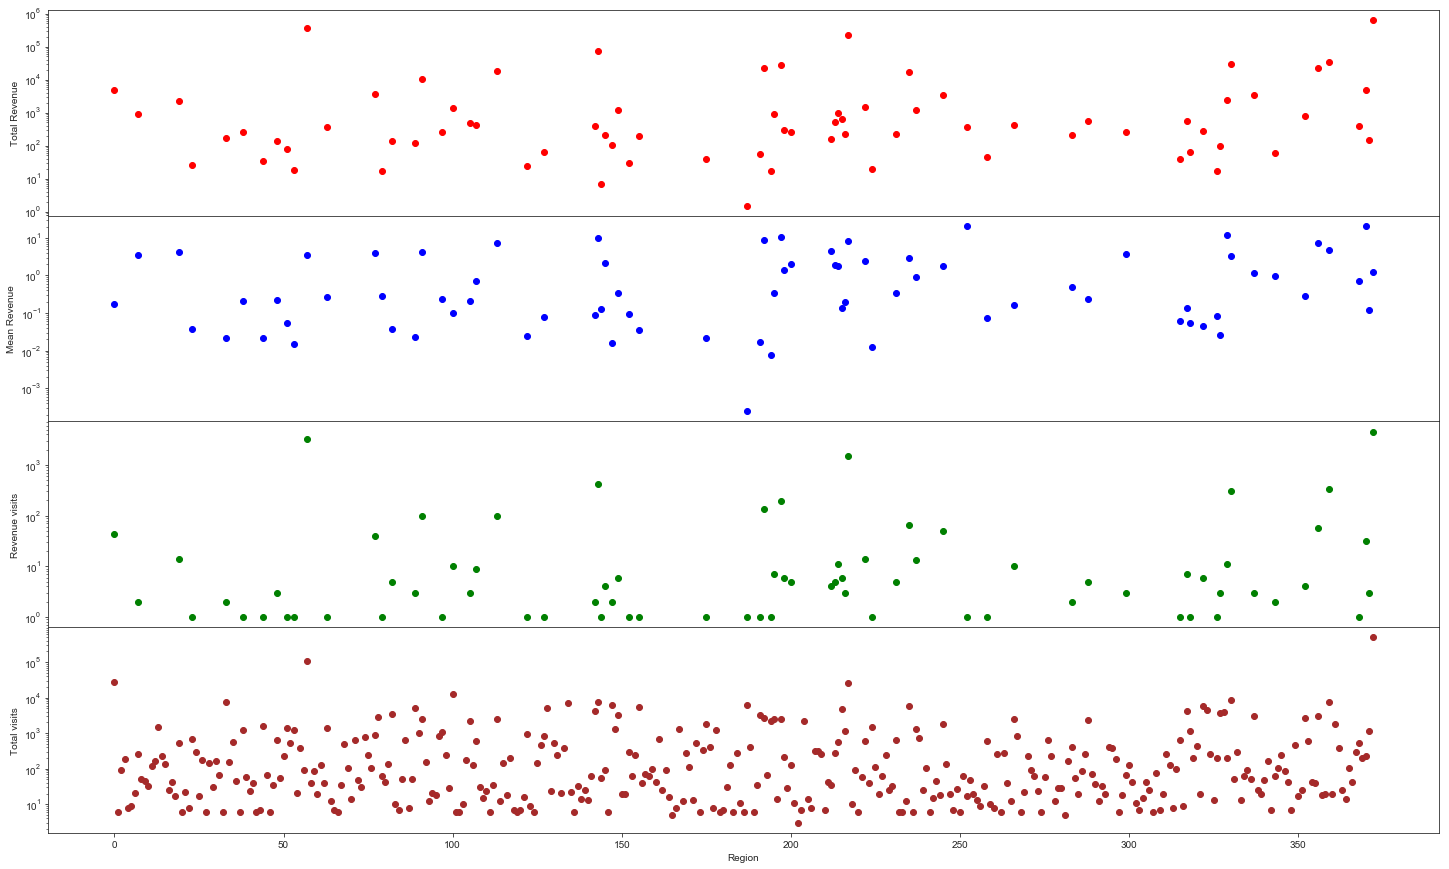

In [94]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Region")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,region_rev.shape[0])
plt1 = ax[0].scatter(x,region_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,region_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,region_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,region_rev['count'].values, color='brown')

In [95]:
# group by days and check the revenues per day
city_rev = train_df.groupby('geoNetwork.city')['revenue'].agg(['count','mean','sum'])
city_rev_2 = train_df.groupby('geoNetwork.city')['revenue'].apply(lambda x: np.count_nonzero(x))

In [96]:
city_rev = city_rev.join(city_rev_2)
city_rev

,count,mean,sum,revenue
geoNetwork.city,,,,
's Hertogenbosch,7,0.000000,0.00,0
(not set),34262,0.127111,4355.09,49
Aalborg,41,0.000000,0.00,0
Aalen,9,0.000000,0.00,0
Aberdeen,21,0.000000,0.00,0
...,...,...,...,...
Zhongli District,240,0.000000,0.00,0
Zhudong Township,17,0.000000,0.00,0
Zurich,1171,0.122681,143.66,3


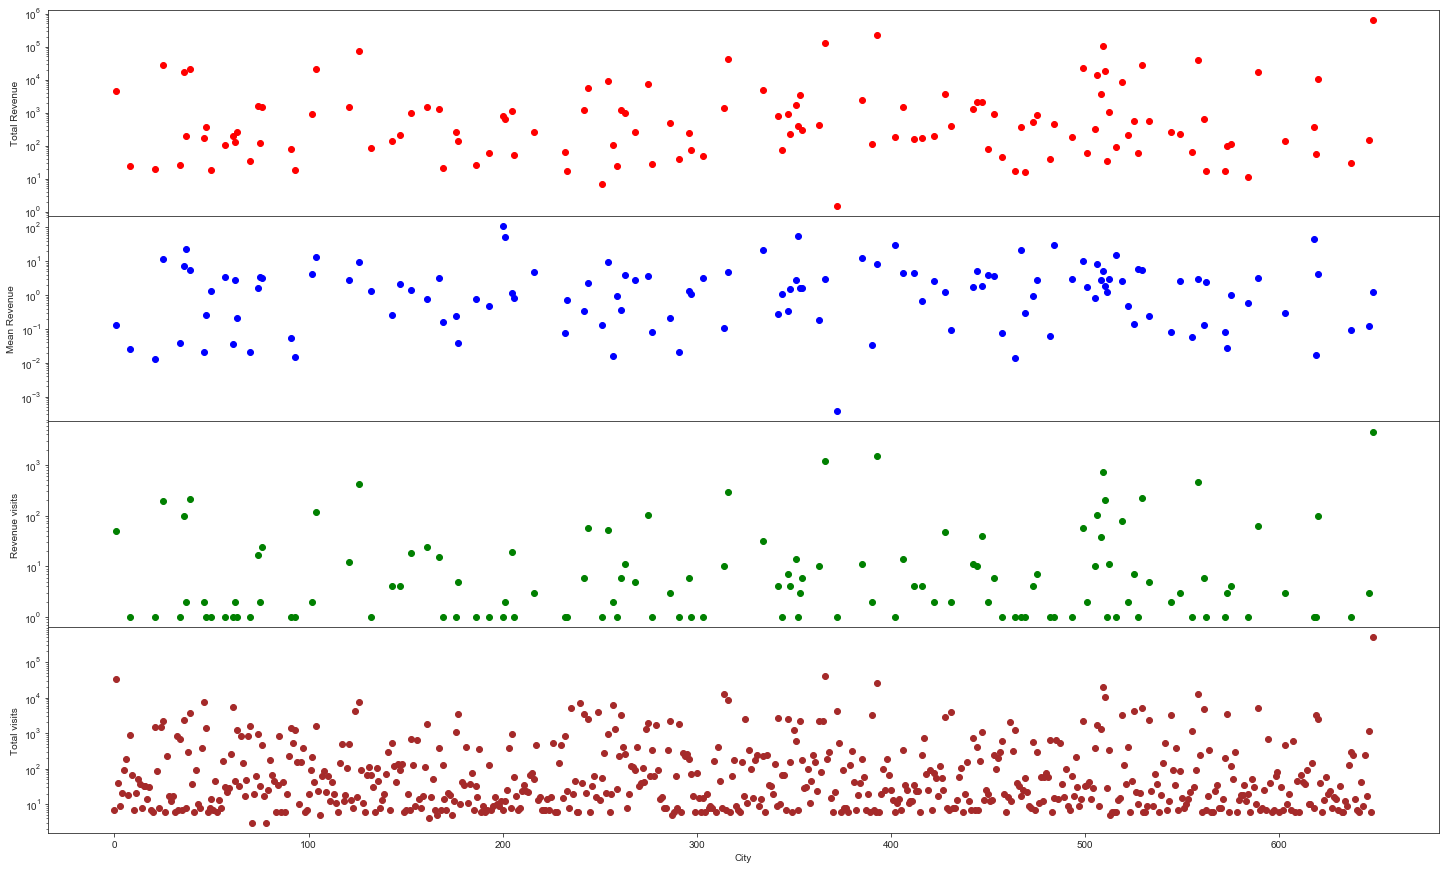

In [97]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("City")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,city_rev.shape[0])
plt1 = ax[0].scatter(x,city_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,city_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,city_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,city_rev['count'].values, color='brown')

In [98]:
# group by days and check the revenues per day
metro_rev = train_df.groupby('geoNetwork.metro')['revenue'].agg(['count','mean','sum'])
metro_rev_2 = train_df.groupby('geoNetwork.metro')['revenue'].apply(lambda x: np.count_nonzero(x))

In [99]:
metro_rev = metro_rev.join(metro_rev_2)

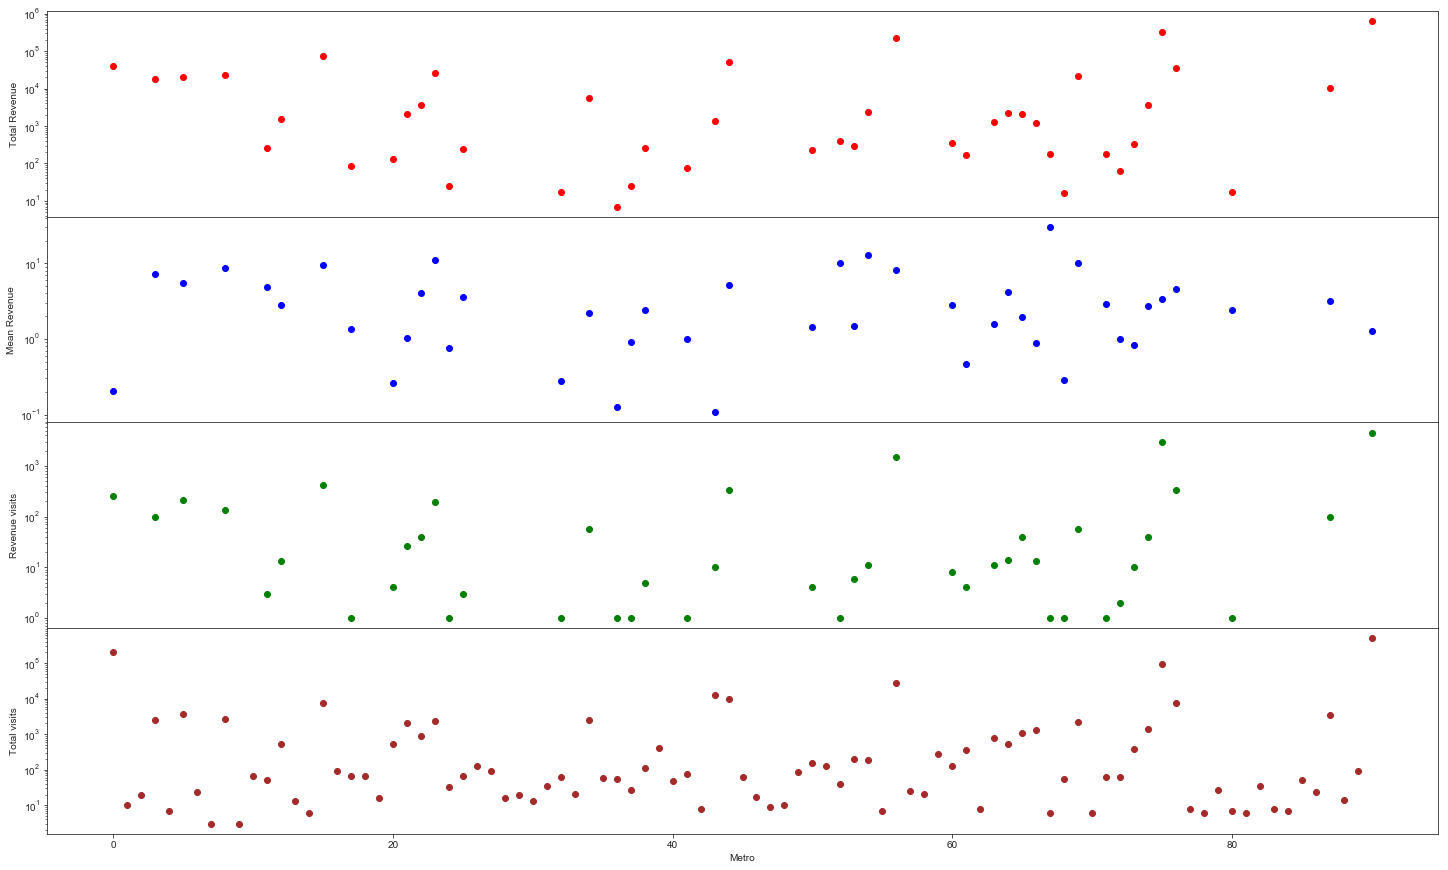

In [100]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Metro")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,metro_rev.shape[0])
plt1 = ax[0].scatter(x,metro_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,metro_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,metro_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,metro_rev['count'].values, color='brown')

In [101]:
# number of unique network domain
train_df['geoNetwork.networkDomain'].nunique()

27996

In [102]:
# group by days and check the revenues per day
domain_rev = train_df.groupby('geoNetwork.networkDomain')['revenue'].agg(['count','mean','sum'])
domain_rev_2 = train_df.groupby('geoNetwork.networkDomain')['revenue'].apply(lambda x: np.count_nonzero(x))
domain_rev = domain_rev.join(domain_rev_2)

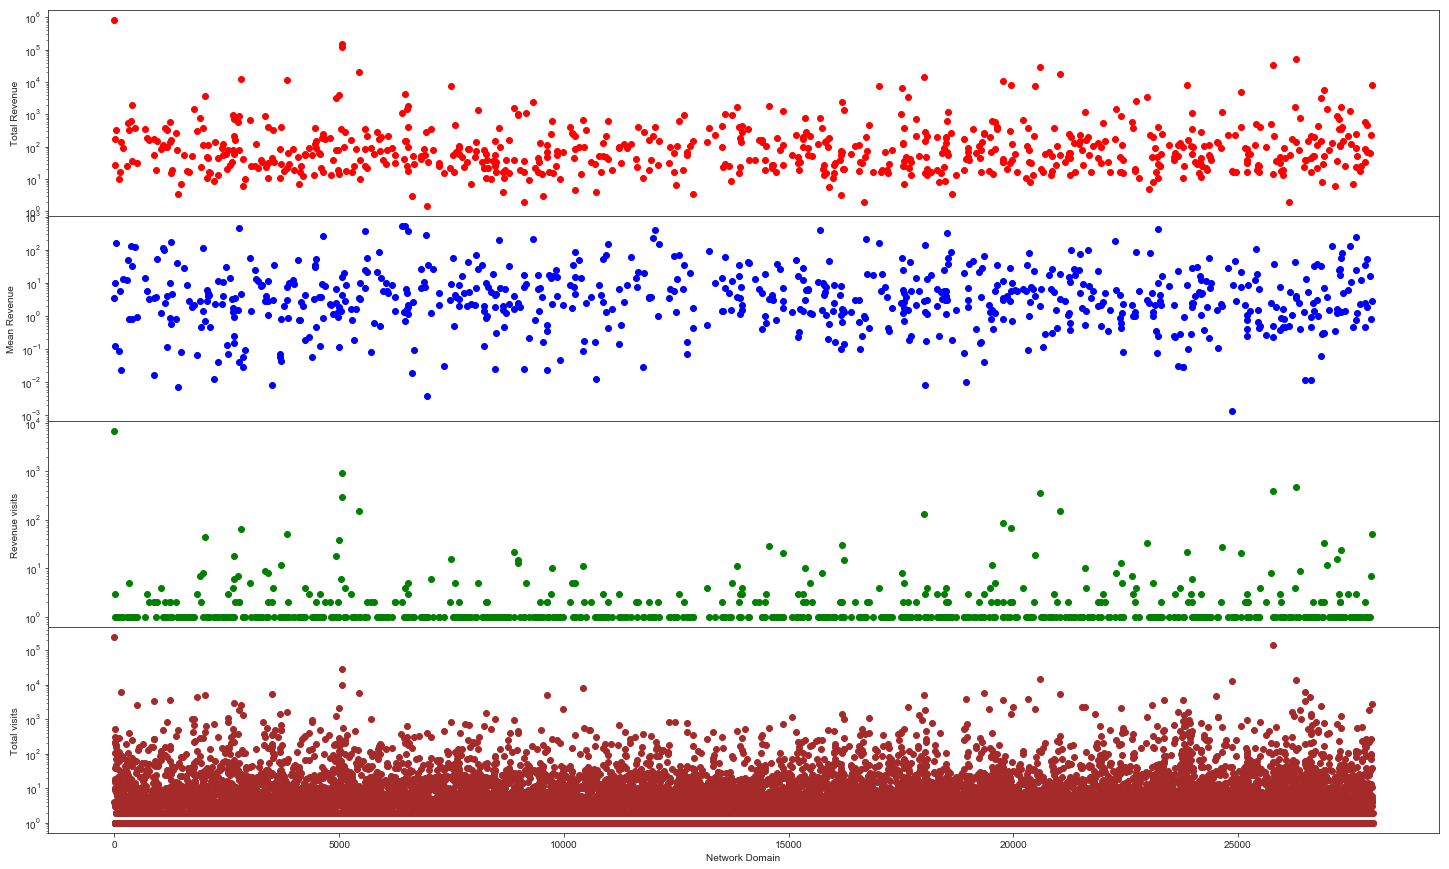

In [103]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Network Domain")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,domain_rev.shape[0])
plt1 = ax[0].scatter(x,domain_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,domain_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,domain_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,domain_rev['count'].values, color='brown')

### Analyze new visits

In [197]:
# Let us check out totals columns
# verify if newVisit is 0 then visitNumber should be greater than 1
train_df[(train_df['totals.newVisits'] == 0) & (train_df['visitNumber'] == 1)].shape

(0, 44)

In [198]:
train_df[(train_df['totals.newVisits'] == 0)].shape

(198501, 44)

In [199]:
# Revenue for newVisits vs non newVisits
newVisits = train_df.groupby('totals.newVisits')['revenue'].agg(['count','mean'])

In [200]:
newVisits

,count,mean
totals.newVisits,,
0,198501,5.801128
1,701387,0.544871


[<Container object of 2 artists>, <Container object of 2 artists>]

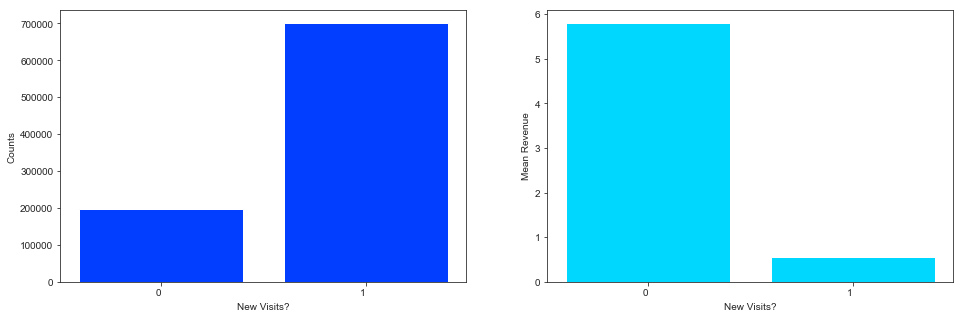

In [204]:
draw_bar_plot(newVisits.index.values,[list(newVisits['count'].values), list(newVisits['mean'].values)],\
              ['New Visits?','New Visits?'],['Counts','Mean Revenue'])

### Bounces

In [205]:
# bounces
bounces = train_df.groupby('totals.bounces')['revenue'].agg(['count','mean'])
bounces

,count,mean
totals.bounces,,
0,451047,3.4003
1,448841,0.0000


[<Container object of 2 artists>, <Container object of 2 artists>]

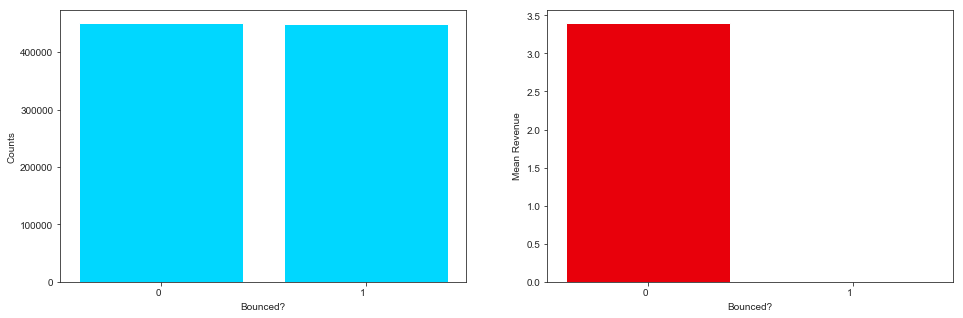

In [206]:
draw_bar_plot(bounces.index.values,[list(bounces['count'].values), list(bounces['mean'].values)],\
              ['Bounced?','Bounced?'],['Counts','Mean Revenue'])

### Analyze Hits

In [111]:
# hits
train_df['totals.hits'].nunique()

273

In [112]:
hits_rev = train_df.groupby('totals.hits')['revenue'].agg(['count','mean','sum'])
hits_rev_2 = train_df.groupby('totals.hits')['revenue'].apply(lambda x: np.count_nonzero(x))
hits_rev = hits_rev.join(hits_rev_2)

In [113]:
hits_rev

,count,mean,sum,revenue
totals.hits,,,,
1,444986,0.000000,0.00,0
2,137412,0.008838,1214.50,4
3,70083,0.003013,211.18,3
4,42245,0.023537,994.30,8
5,30794,0.074106,2282.03,12
...,...,...,...,...
445,1,74.850000,74.85,1
471,1,198.100000,198.10,1
483,1,0.000000,0.00,0


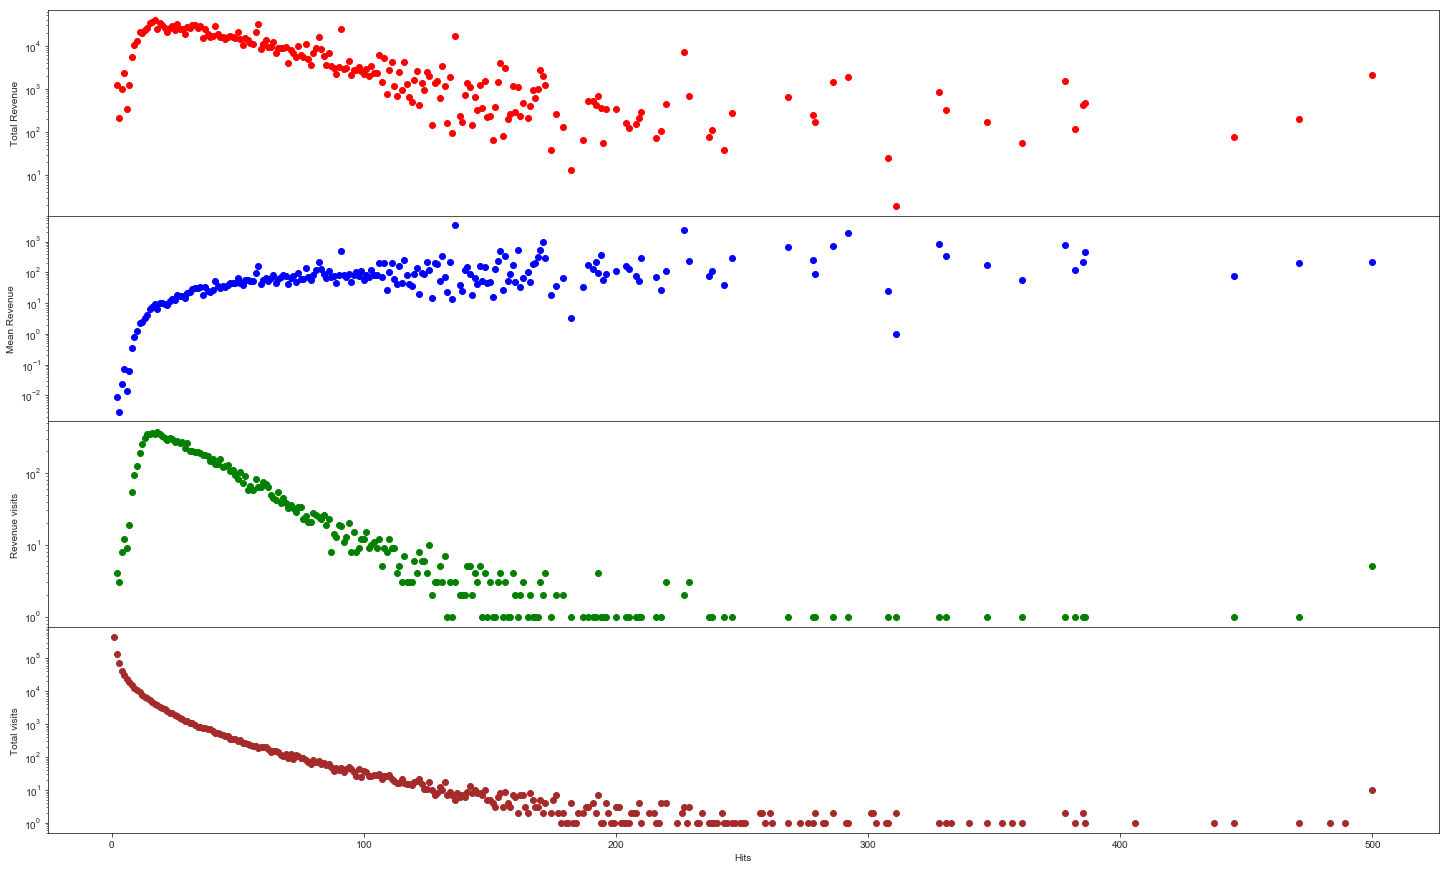

In [114]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Hits")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = hits_rev.index.values
plt1 = ax[0].scatter(x,hits_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,hits_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,hits_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,hits_rev['count'].values, color='brown')

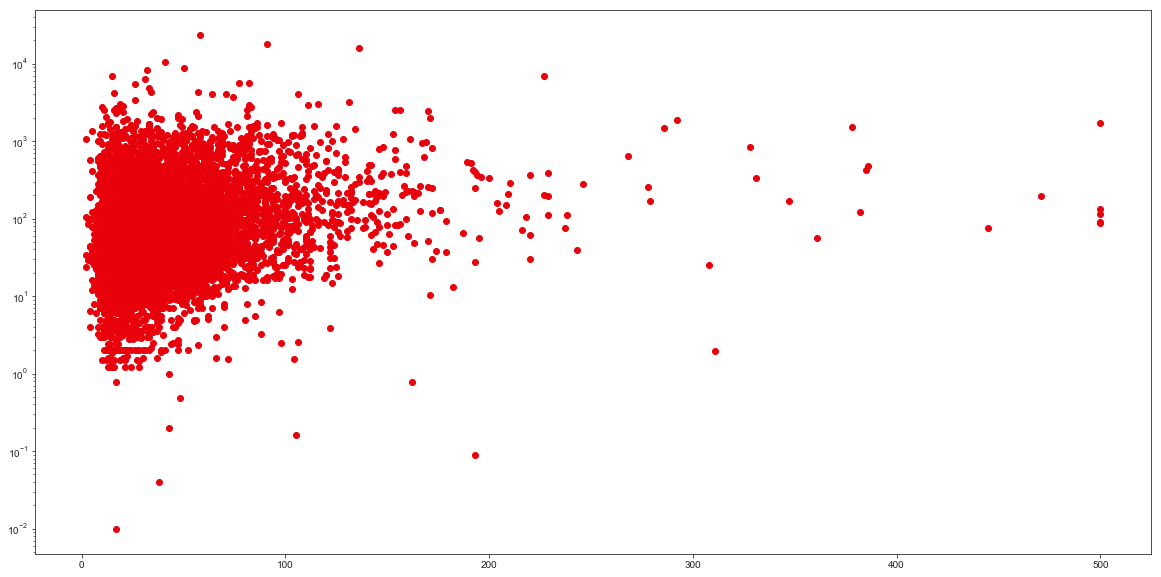

In [115]:
# show all revenues vs hit plot
plt.figure(figsize=(20,10))
plt.yscale('log')
plt.scatter(train_df['totals.hits'], train_df['revenue'], color= get_colors(1))

Above scatter plot indicates that hits below 100 get huge number of transactions as compared to other hit values

### Page Views

In [116]:
pageviews_rev = train_df.groupby('totals.pageviews')['revenue'].agg(['count','mean','sum'])
pageviews_rev_2 = train_df.groupby('totals.pageviews')['revenue'].apply(lambda x: np.count_nonzero(x))
pageviews_rev = pageviews_rev.join(pageviews_rev_2)

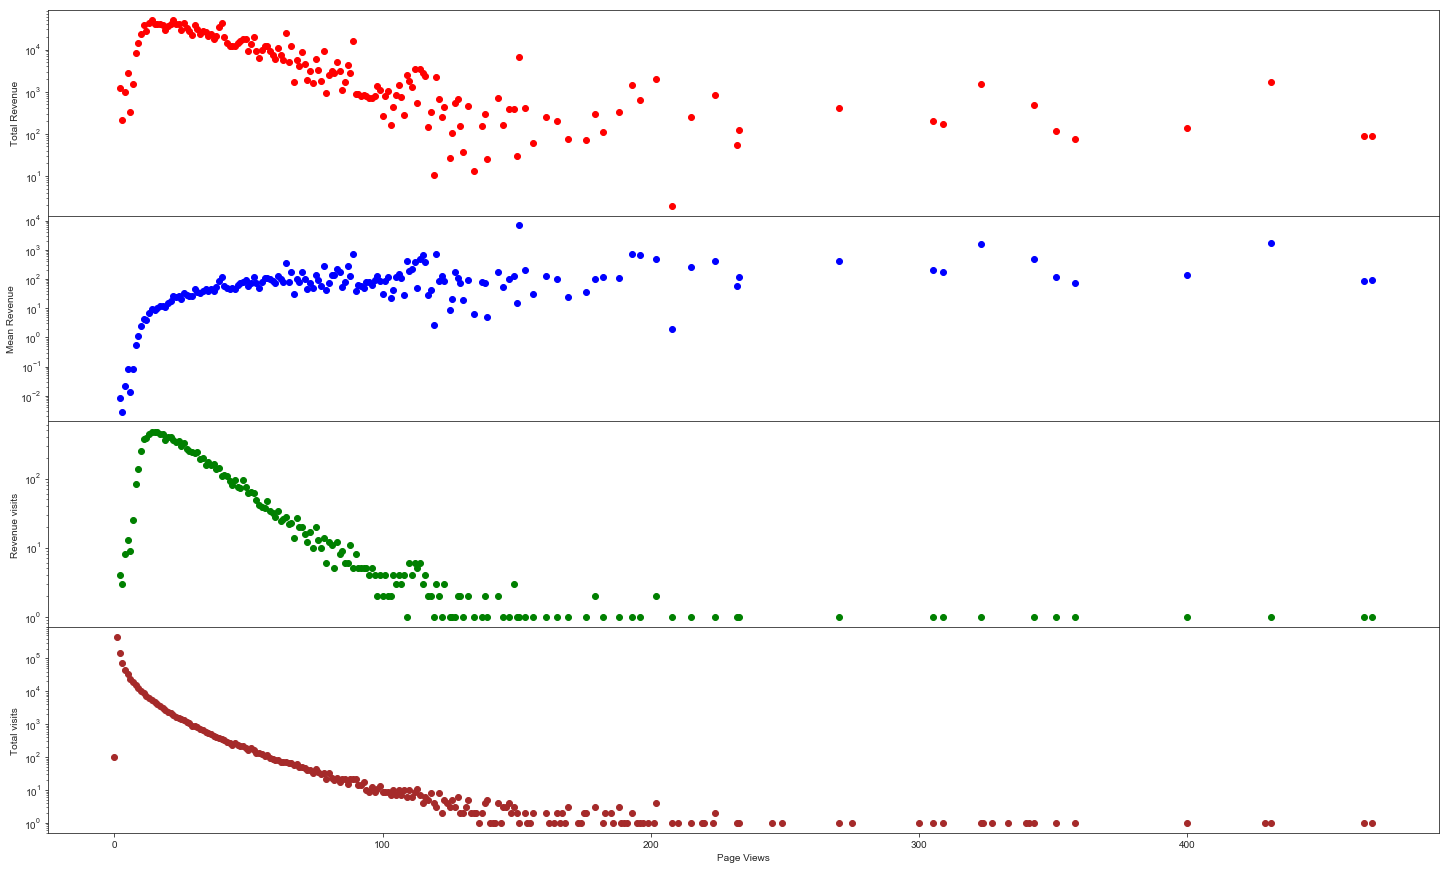

In [117]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Page Views")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = pageviews_rev.index.values
plt1 = ax[0].scatter(x,pageviews_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,pageviews_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,pageviews_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,pageviews_rev['count'].values, color='brown')

### Traffic source

In [207]:
# trafficSource source
train_df['trafficSource.source'].nunique()

379

In [208]:
unique_sources = train_df['trafficSource.source'].unique()

In [209]:
map_sources_int = {}
i = 0
for key in unique_sources:
    i += 1
    map_sources_int.update({key: i})

In [210]:
sorted_sources = sorted(map_sources_int.items(), key=lambda kv: kv[1])
sorted_sources

[('google', 1),
 ('baidu', 2),
 ('googleweblight.com', 3),
 ('sites.google.com', 4),
 ('bing', 5),
 ('siliconvalley.about.com', 6),
 ('analytics.google.com', 7),
 ('Partners', 8),
 ('(direct)', 9),
 ('mall.googleplex.com', 10),
 ('google.com', 11),
 ('google.co.in', 12),
 ('qiita.com', 13),
 ('google.pl', 14),
 ('mail.google.com', 15),
 ('hangouts.google.com', 16),
 ('dealspotr.com', 17),
 ('optimize.google.com', 18),
 ('arstechnica.com', 19),
 ('dfa', 20),
 ('docs.google.com', 21),
 ('sashihara.jp', 22),
 ('google.gatewaycdi.com', 23),
 ('phandroid.com', 24),
 ('images.google', 25),
 ('youtube.com', 26),
 ('l.facebook.com', 27),
 ('facebook.com', 28),
 ('quora.com', 29),
 ('m.facebook.com', 30),
 ('reddit.com', 31),
 ('google.co.jp', 32),
 ('aol', 33),
 ('moma.corp.google.com', 34),
 ('blog.golang.org', 35),
 ('yahoo', 36),
 ('t.co', 37),
 ('nordic.businessinsider.com', 38),
 ('duckduckgo.com', 39),
 ('m.baidu.com', 40),
 ('tpc.googlesyndication.com', 41),
 ('googleads.g.doubleclick.n

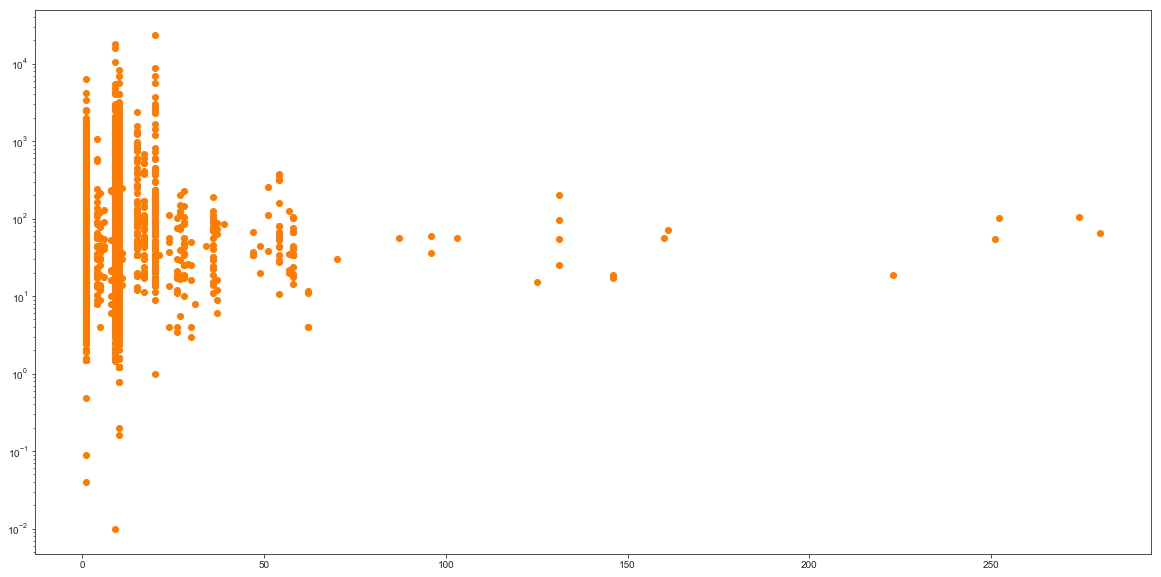

In [211]:
plt.figure(figsize=(20,10))
plt.yscale('log')
x = train_df['trafficSource.source'].apply(lambda x: map_sources_int.get(x))
plt.scatter(x, train_df['revenue'], color=get_colors(1))

In [212]:
# trafficSource referral path
train_df['trafficSource.referralPath'].nunique()

1473

### Traffic source medium

In [213]:
# trafficSource medium
train_df['trafficSource.medium'].nunique()

7

In [214]:
# bounces
medium_rev = train_df.groupby('trafficSource.medium')['revenue'].agg(['count','mean'])
medium_rev

,count,mean
trafficSource.medium,,
(none),142449,3.044255
(not set),116,0.086121
affiliate,16305,0.036638
cpc,25247,1.722665
cpm,6240,12.554080
organic,379805,0.856255
referral,329726,1.978604


[<Container object of 7 artists>, <Container object of 7 artists>]

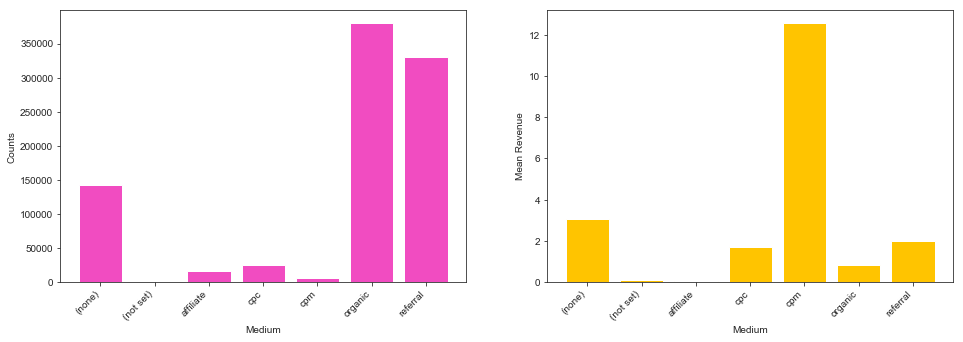

In [215]:
draw_bar_plot(medium_rev.index.values,[list(medium_rev['count'].values), list(medium_rev['mean'].values)],\
              ['Medium','Medium'],['Counts','Mean Revenue'],x_rotation=45)

### Traffice source keyword

In [216]:
train_df['trafficSource.keyword'].nunique()

3653

In [217]:
keyword_rev = train_df.groupby('trafficSource.keyword')['revenue'].agg(['count','mean','sum'])
keyword_rev_2 = train_df.groupby('trafficSource.keyword')['revenue'].apply(lambda x: np.count_nonzero(x))
keyword_rev = keyword_rev.join(keyword_rev_2)

In [218]:
keyword_rev.sort_values('count',ascending=False,inplace=True)
non_zero_keyword_rev = keyword_rev[keyword_rev['revenue']>0]

In [219]:
print(non_zero_keyword_rev.index.values)

['Unknown' '(not provided)' '6qEhsCssdK0z36ri'
 '(Remarketing/Content targeting)' '1hZbAqLCbjwfgOH7'
 'google merchandise store' 'Google Merchandise' 'google store'
 '1X4Me6ZKNV0zg-jV' '(automatic matching)' '+google +store'
 '+Google +Merchandise' '+google +merchandise +store'
 'YouTube Merchandise' 'youtube merch' 'google merchandise' 'google merch'
 '+google +stores' '+Google +Swag' 'google store merchandise'
 '+google +merch' 'google stickers' 'category_l1==166' 'google shirt'
 '+Google +Gear' '+google+tshirts' 'youtube merchandise store'
 'googlemerchandisestore' 'google apparel store' 'googlesupport'
 'google items for sale' 'GOOGLE MERCHANDISE' 'Youtube merchandise store'
 'you tube trucker cap google merchandise' '+google +coffee +mug'
 "google men's hoodie pullover"]


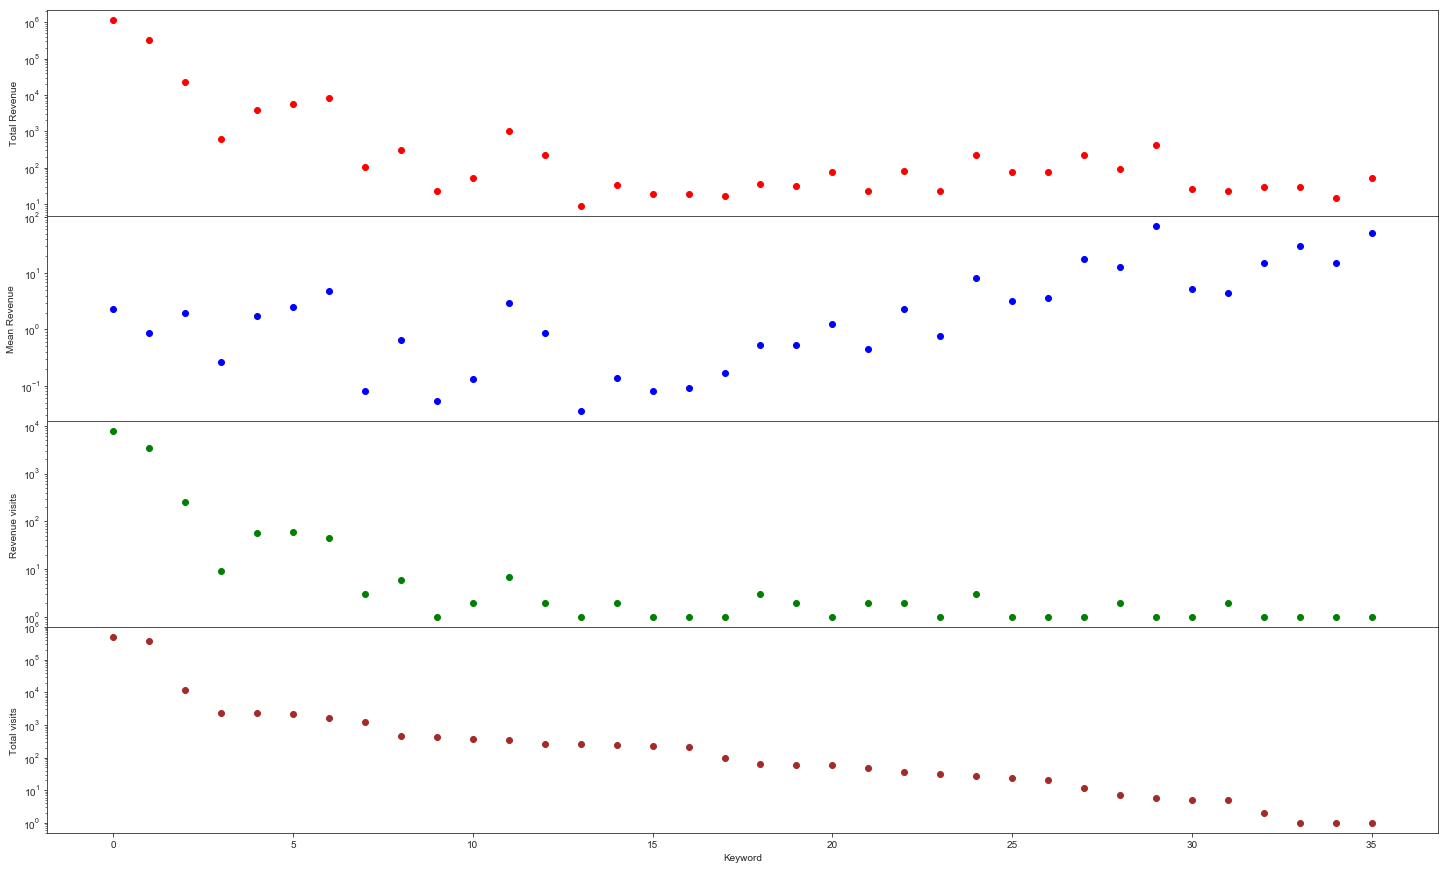

In [220]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("Keyword")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,non_zero_keyword_rev.shape[0])
plt1 = ax[0].scatter(x,non_zero_keyword_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,non_zero_keyword_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,non_zero_keyword_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,non_zero_keyword_rev['count'].values, color='brown')

### Traffice source isTrueDirect

[<Container object of 2 artists>, <Container object of 2 artists>]

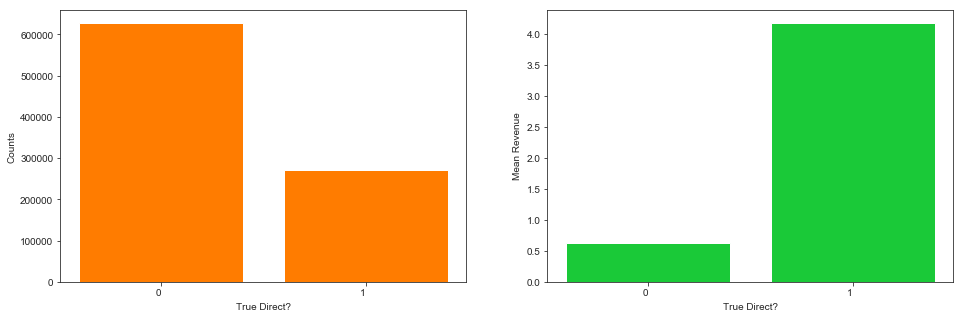

In [221]:
# true direct
true_direct = train_df.groupby('trafficSource.isTrueDirect')['revenue'].agg(['count','mean'])
true_direct

draw_bar_plot(true_direct.index.values,[list(true_direct['count'].values), list(true_direct['mean'].values)],\
              ['True Direct?','True Direct?'],['Counts','Mean Revenue'])

### Traffice source campaign

In [222]:
# unique cmapaign
train_df['trafficSource.campaign'].nunique()

10

[<Container object of 10 artists>, <Container object of 10 artists>]

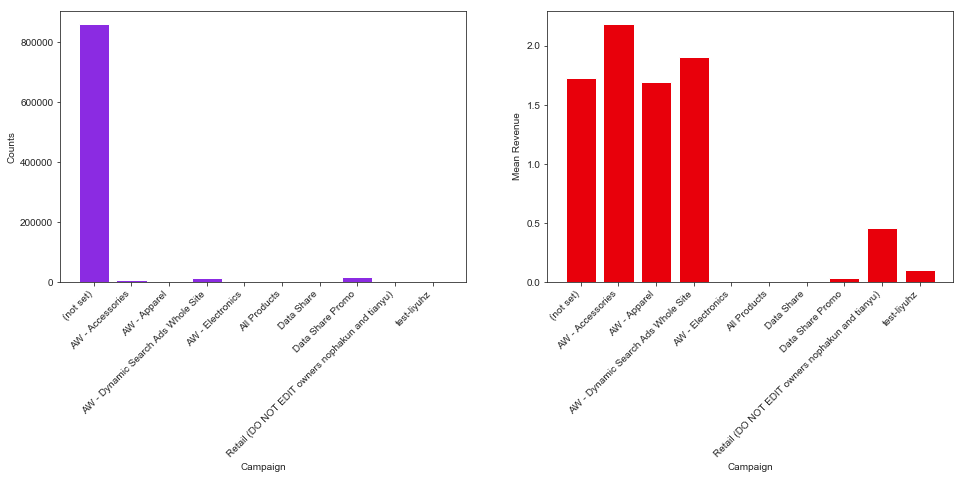

In [223]:
# campaign
campaign = train_df.groupby('trafficSource.campaign')['revenue'].agg(['count','mean'])
campaign

draw_bar_plot(campaign.index.values,[list(campaign['count'].values), list(campaign['mean'].values)],\
              ['Campaign','Campaign'],['Counts','Mean Revenue'], x_rotation=45)

In [224]:
# unique cmapaign
# this is doubtful check later
train_df[train_df['trafficSource.campaignCode']==1].shape

(899887, 44)

[<Container object of 2 artists>, <Container object of 2 artists>]

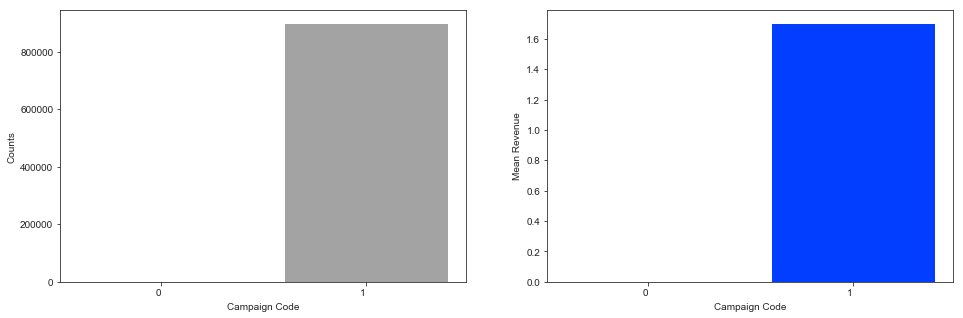

In [225]:
# true direct
campaign_code = train_df.groupby('trafficSource.campaignCode')['revenue'].agg(['count','mean'])

draw_bar_plot(campaign_code.index.values,[list(campaign_code['count'].values), list(campaign_code['mean'].values)],\
              ['Campaign Code','Campaign Code'],['Counts','Mean Revenue'])

### TrafficSource adwordsClickInfo slot

[<Container object of 3 artists>, <Container object of 3 artists>]

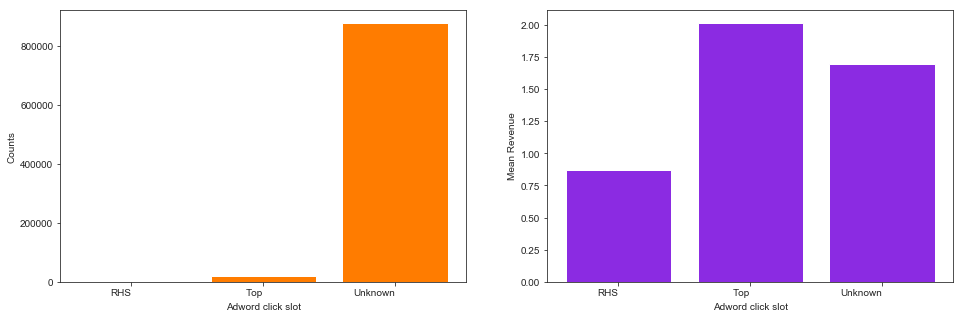

In [226]:
# trafficSource.adwordsClickInfo.slot
avg_rev_slot = train_df.groupby('trafficSource.adwordsClickInfo.slot')['revenue'].agg(['count','mean'])

draw_bar_plot(avg_rev_slot.index.values,[list(avg_rev_slot['count'].values), list(avg_rev_slot['mean'].values)],\
              ['Adword click slot','Adword click slot'],['Counts','Mean Revenue'])

### TrafficSource adwordsClickInfo page

In [138]:
train_df['trafficSource.adwordsClickInfo.page'].nunique()

9

[<Container object of 9 artists>, <Container object of 9 artists>]

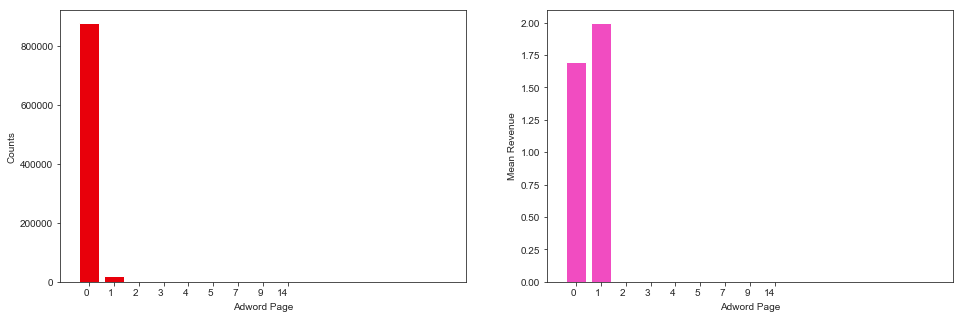

In [139]:
# trafficSource.adwordsClickInfo.page
page_rev = train_df.groupby('trafficSource.adwordsClickInfo.page')['revenue'].agg(['count','mean'])

draw_bar_plot(page_rev.index.values,[list(page_rev['count'].values), list(page_rev['mean'].values)],\
              ['Adword Page','Adword Page'],['Counts','Mean Revenue'])

### TrafficSource adwordsClickInfo isVideoAd

[<Container object of 2 artists>, <Container object of 2 artists>]

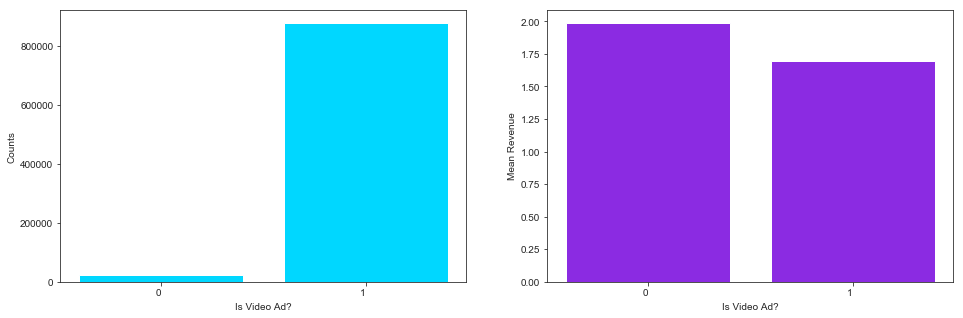

In [140]:
video_ad_rev = train_df.groupby('trafficSource.adwordsClickInfo.isVideoAd')['revenue'].agg(['count','mean'])

draw_bar_plot(video_ad_rev.index.values,[list(video_ad_rev['count'].values), list(video_ad_rev['mean'].values)],\
              ['Is Video Ad?','Is Video Ad?'],['Counts','Mean Revenue'])

### TrafficSource adwordsClickInfo gclId

In [141]:
train_df['trafficSource.adwordsClickInfo.gclId'].nunique()

17754

In [142]:
gcl_id_rev = train_df.groupby('trafficSource.adwordsClickInfo.gclId')['revenue'].agg(['count','mean','sum'])
gcl_id_rev_2 = train_df.groupby('trafficSource.adwordsClickInfo.gclId')['revenue'].apply(lambda x: np.count_nonzero(x))
gcl_id_rev = gcl_id_rev.join(gcl_id_rev_2)

gcl_id_rev.sort_values('count',ascending=False,inplace=True)

In [143]:
gcl_id_rev

,count,mean,sum,revenue
trafficSource.adwordsClickInfo.gclId,,,,
Unknown,878373,1.697361,1490916.16,11011
Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3ZdwYO8GTsjiBFd5MPHStZa9y_9NCrI8X97oaAglc8P8HAQ,70,0.000000,0.00,0
Cj0KEQjw1ee_BRD3hK6x993YzeoBEiQA5RH_BEA562M9tvl_mtnAFvtDnDqOQRp1RvxMMgwjcX1LAfwaAj4o8P8HAQ,41,0.000000,0.00,0
CJH1vbf94M8CFUElgQodyakHgQ,29,0.000000,0.00,0
Cj0KEQiAw_DEBRChnYiQ_562gsEBEiQA4LcssmB_RWgvpPnltzlzj5rGwqx5lk87wC5CjfcqzneNZewaAiAp8P8HAQ,27,0.000000,0.00,0
...,...,...,...,...
Cj0KEQiA-MPCBRCZ0q23tPGm6_8BEiQAgw_bAjnNWIV5hUlAK-v5DnOZAYBp6RqBdyWzUlCU_dzW5o8aAio-8P8HAQ,1,0.000000,0.00,0
Cj0KEQiA-MPCBRCZ0q23tPGm6_8BEiQAgw_bAkNRJYtNFGnNnsehFL3IUaQP0-ZF_tGyZvO2H2sXcbkaAhAH8P8HAQ,1,0.000000,0.00,0
Cj0KEQiA-MPCBRCZ0q23tPGm6_8BEiQAgw_bAkNhy9mmc0ew68gf88a6tjYmG3mjKYOcjBAiOSR7RYoaAu438P8HAQ,1,0.000000,0.00,0


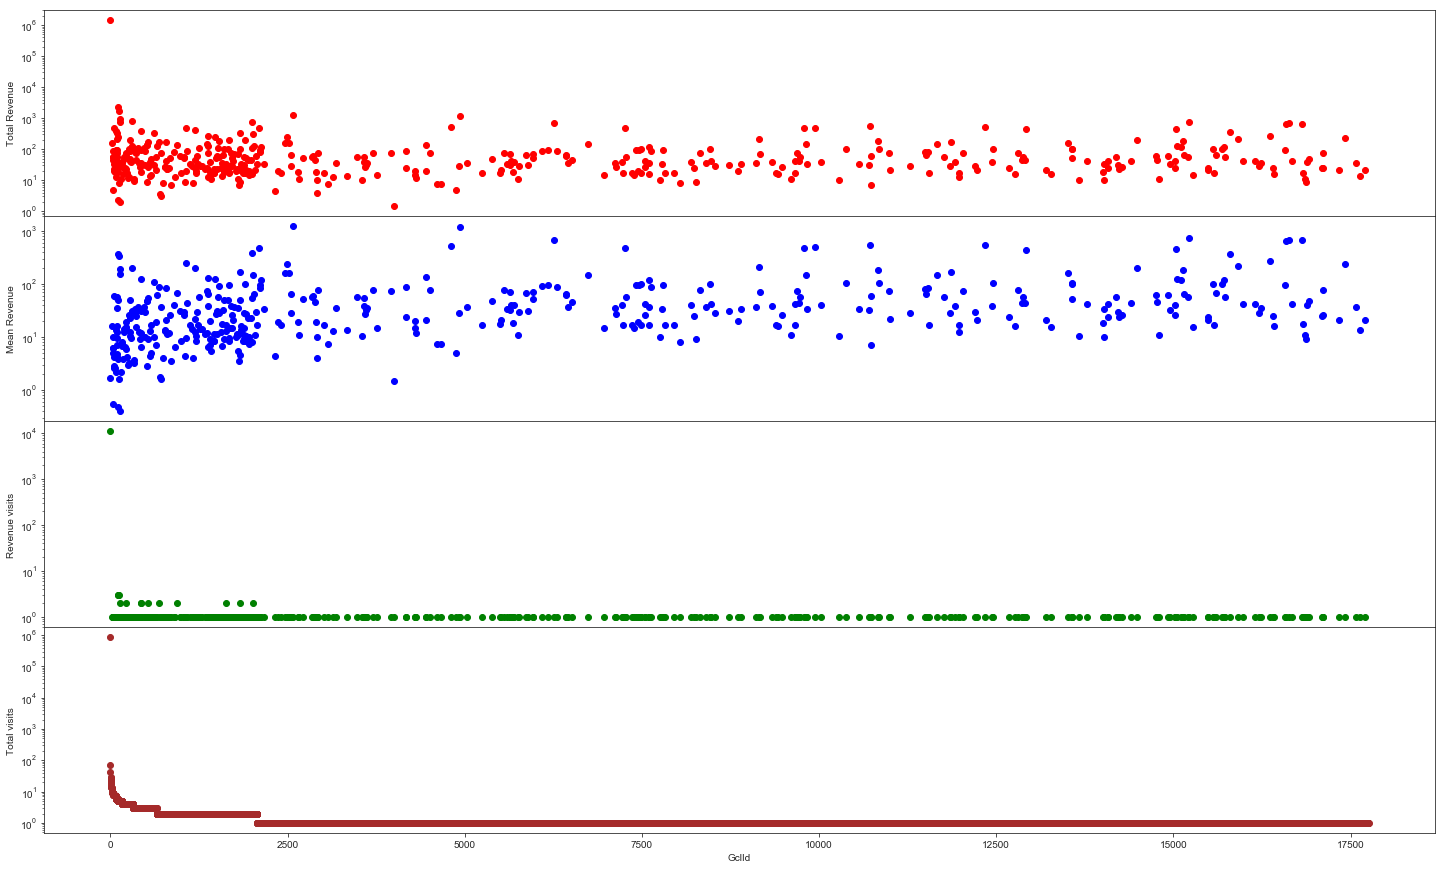

In [144]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("GclId")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,gcl_id_rev.shape[0])
plt1 = ax[0].scatter(x,gcl_id_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,gcl_id_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,gcl_id_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,gcl_id_rev['count'].values, color='brown')

In [145]:
train_df['revenue'].sum()

1533695.2200000002

In [146]:
train_df[train_df['trafficSource.adwordsClickInfo.gclId']=='Unknown']['revenue'].sum()

1490916.1599999997

### TrafficSource adwordsClickInfo adNetworkType

In [147]:
train_df['trafficSource.adwordsClickInfo.adNetworkType'].unique()

array(['Unknown', 'Google Search', 'Search partners'], dtype=object)

[<Container object of 3 artists>, <Container object of 3 artists>]

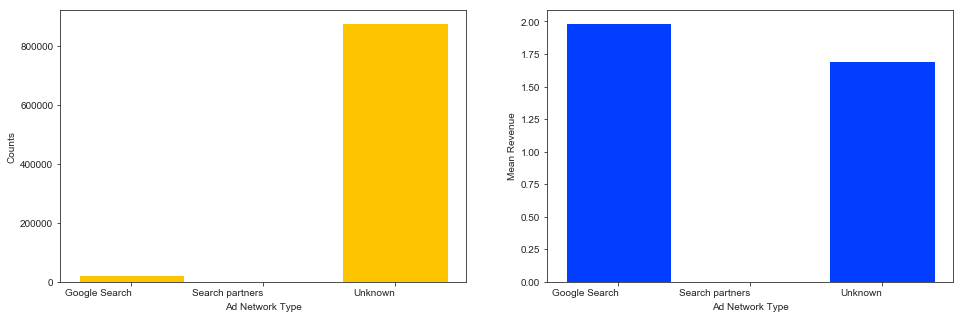

In [238]:
ad_network_rev = train_df.groupby('trafficSource.adwordsClickInfo.adNetworkType')['revenue'].agg(['count','mean'])

draw_bar_plot(ad_network_rev.index.values,[list(ad_network_rev['count'].values), list(ad_network_rev['mean'].values)],\
              ['Ad Network Type','Ad Network Type'],['Counts','Mean Revenue'])

### TrafficSource adContent

In [231]:
train_df['trafficSource.adContent'].unique()

array(['Others', 'Full auto ad IMAGE ONLY',
       'First Full Auto Template Test Ad', '{KeyWord:Google Brand Items}',
       'Display Ad created 3/11/14', 'Ad from 11/7/16',
       'Display Ad created 3/11/15', 'Ad from 12/13/16',
       'Ad from 11/3/16', 'Google Online Store',
       'Google Merchandise Collection', '{KeyWord:Want Google Stickers?}',
       '{KeyWord:Google Merchandise}', 'Display Ad created 11/17/14',
       '{KeyWord:Google Drinkware}', "{KeyWord:Google Men's T-Shirts}",
       '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}', 'Google Paraphernalia',
       'Swag with Google Logos', '{KeyWord:Google Branded Kit}',
       'Want Google Sunglasses', '{KeyWord:Looking for Google Bags?}',
       'Full auto ad TEXT ONLY', 'Google Merchandise', 'google store',
       'LeEco_1a', 'Full auto ad TEXT/NATIVE',
       '{KeyWord:Want Google Pet Toys?}', 'Google Store',
       "Men's-Outerwear Google Apparel", '20% discount',
       'Full auto ad with 

In [232]:
ad_content_rev = train_df.groupby('trafficSource.adContent')['revenue'].agg(['count','mean','sum'])
ad_content_rev_2 = train_df.groupby('trafficSource.adContent')['revenue'].apply(lambda x: np.count_nonzero(x))
ad_content_rev = ad_content_rev.join(ad_content_rev_2)

ad_content_rev.sort_values('count',ascending=False,inplace=True)

In [233]:
ad_content_rev

,count,mean,sum,revenue
trafficSource.adContent,,,,
Others,888998,1.706963,1517486.52,11322
Google Merchandise Collection,5100,2.933002,14958.31,117
Google Online Store,1245,0.131261,163.42,4
Display Ad created 3/11/14,942,0.320924,302.31,3
Full auto ad IMAGE ONLY,817,0.321151,262.38,5
...,...,...,...,...
Swag w/ Google Logos,1,0.000000,0.00,0
google store,1,0.000000,0.00,0
visit us again,1,0.000000,0.00,0


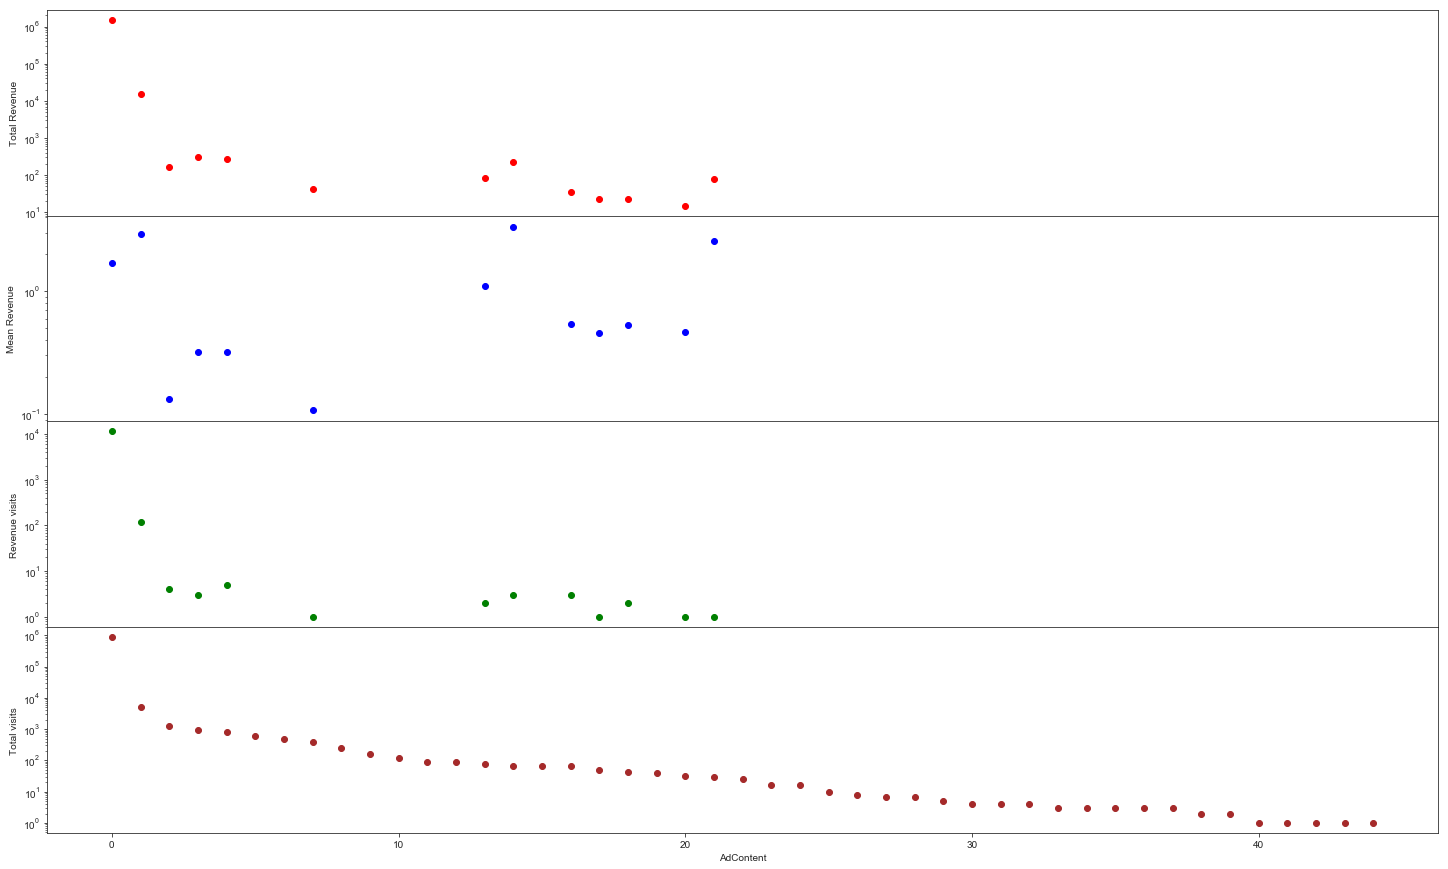

In [234]:
# plot the day revenues 
fig, ax = plt.subplots(4,1,sharex=True)
fig.set_size_inches(w=20,h=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax.set_xticks(np.arange(0,365,7))
ax[3].set_xlabel("AdContent")
ax[0].set_ylabel("Total Revenue")
ax[1].set_ylabel("Mean Revenue")
ax[2].set_ylabel("Revenue visits")
ax[3].set_ylabel("Total visits")

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

x = np.arange(0,ad_content_rev.shape[0])
plt1 = ax[0].scatter(x,ad_content_rev['sum'].values, color='red')
plt2 = ax[1].scatter(x,ad_content_rev['mean'].values, color='blue')
plt3 = ax[2].scatter(x,ad_content_rev['revenue'].values, color='green')
plt3 = ax[3].scatter(x,ad_content_rev['count'].values, color='brown')

In [235]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,revenue,year,month,day,weekday,hour,day_of_year,local_hour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,2,4,15,245,1
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,5,246,5
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,(not provided),organic,Unknown,google,0.0,2016,9,3,5,1,246,10
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1,1,1,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,0,google + online,organic,Unknown,google,0.0,2016,9,3,5,5,246,5
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1,1,0,1,0.0,Others,Unknown,Unknown,1,0,Unknown,(not set),1,1,(not provided),organic,Unknown,google,0.0,2016,9,2,4,13,245,13


In [236]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899888 entries, 0 to 903652
Data columns (total 44 columns):
channelGrouping                                 899888 non-null object
date                                            899888 non-null int64
fullVisitorId                                   899888 non-null object
sessionId                                       899888 non-null object
visitId                                         899888 non-null int64
visitNumber                                     899888 non-null int64
visitStartTime                                  899888 non-null int64
device.browser                                  899888 non-null object
device.deviceCategory                           899888 non-null object
device.isMobile                                 899888 non-null bool
device.operatingSystem                          899888 non-null object
geoNetwork.city                                 899888 non-null object
geoNetwork.continent                       

In [237]:
# In this analysis we have created some more columns out data/time and revenue
# Let us save those for now
train_df.to_csv('../data/extra_cols_train.csv')